In this notebook, Xgboost estimator is evaluated against different datasets configurations.

Xgboost is activated with an option allowing to balance minority classes.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, header="Gradient Boosting classification")

In [1]:
import numpy as np
import time

import tensorflow as tf
import pandas as pd
import gensim

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import p8_util
import p8_util_config
import p9_util

import p5_util

extension='_part'

W0827 13:34:49.796990 139773840095040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0827 13:34:49.797835 139773840095040 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

Using TensorFlow backend.
W0827 13:34:50.110344 139773840095040 deprecation_wrapper.py:119] From /home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p8_util_config.py:137: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



In [197]:
OUTPUT_DIR = './tmp/baseline'
OUTPUT_DIR_TB = './tmp'
is_tensorboard = False

In [686]:
#### Tensorboard processes are killed

In [198]:
# this will kill the processes for Tensorboard
#is_tensorboard = True
if is_tensorboard is True :
    !ps aux | grep tensorboard | awk '{print $2}' | xargs kill
# this will kill the processes for ngrok
if is_tensorboard is True :
    !ps aux | grep ngrok | awk '{print $2}' | xargs kill    

# <font color=blus>1 Dataset exploration</font>

    This step aims to discover relationships between features in data model.
    An appropriate estimator will be selected. Based on these relations, 

## <font color=blus>1.1 Loading Dataset</font>

In [5]:
! ls -alrth ./data/dataPreparator_*

-rwxrwxrwx 1 bangui bangui   97K oct.  24 01:15 ./data/dataPreparator_train_12000.dill
-rwxrwxrwx 1 bangui bangui   97K oct.  24 01:17 ./data/dataPreparator_valid_12000.dill
-rwxrwxrwx 1 bangui bangui 1020K oct.  24 01:17 ./data/dataPreparator_train_129651.dill


In [3]:
n_sample=15000

In [37]:
import numpy as np
import p5_util

filename_train = './data/DataPreparator_train_spacy_'+str(n_sample)+'.dump'

if False :
    p5_util.object_dump(dataPreparator_train,filename_train)
else : 
    dataPreparator_train = p5_util.object_load(filename_train)
    
print("")
print("DataPretarator train lenth= {}".format(len(dataPreparator_train)))


vocab_size = len(dataPreparator_train.kerasTokenizer.tokenizer.word_index) + 1
print("Vocabulary size= {}".format(vocab_size))

X_train = dataPreparator_train.X
y_train = dataPreparator_train.y
print("")
print("Train dataset : X_train shape= {}, y_train shape= {}".format(X_train.shape, y_train.shape))

print("")
filename_test = './data/DataPreparator_test_spacy_'+str(n_sample)+'.dump'

if False :
    p5_util.object_dump(dataPreparator_test,filename_test)
else : 
    dataPreparator_test = p5_util.object_load(filename_test)
    
print("")
print("DataPretarator test lenth=  {}".format(len(dataPreparator_test)))


X_test = dataPreparator_test.X
y_test = dataPreparator_test.y
print("")
print("Test dataset : X_test shape= {}, y_test shape= {}".format(X_test.shape, y_test.shape))

valid_sample = X_train.shape[0]//3
valid_sample
X_test = X_test[:valid_sample,:]
y_test = y_test[:valid_sample]
print("")
print("Sample of test dataset : X_test shape= {}, y_test shape= {}".format(X_test.shape, y_test.shape))

p5_util.object_load : fileName= ./data/DataPreparator_train_spacy_15000.dump

DataPretarator train lenth= 13623
Vocabulary size= 1

Train dataset : X_train shape= (13623, 300), y_train shape= (13623,)
p5_util.object_load : fileName= ./data/DataPreparator_test_spacy_15000.dump

DataPretarator test lenth=  13616

Test dataset : X_test shape= (13616, 300), y_test shape= (13616,)

Sample of test dataset : X_test shape= (4541, 300), y_test shape= (4541,)


In [43]:

X_train = dataPreparator_train.X
y_train = dataPreparator_train.y

X_test = dataPreparator_test.X
y_test = dataPreparator_test.y


In [44]:
print(y_train.min(), y_train.max())
X_train.shape, y_train.shape, X_test.shape, y_test.shape

0.0 1.0


((13623, 300), (13623,), (13616, 300), (13616,))

### <font color=blus>1.1. Loading data generators for train and validation</font>

In [6]:
import p5_util

filename_train = './data/train_generator.dill'
filename_valid = './data/valid_generator.dill'

train_generator = p5_util.object_load(filename_train)
valid_generator = p5_util.object_load(filename_valid)
    

p5_util.object_load : fileName= ./data/train_generator.dill


Using TensorFlow backend.
/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
W1101 23:04:16.649593 139755362248512 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1101 23:04:16.650536 139755362248512 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W1101 23:0

p5_util.object_load : fileName= ./data/valid_generator.dill


In [11]:
X_valid = valid_generator.X

In [20]:
y_valid.shape

(1000, 2)

In [22]:
X_train = train_generator._get_X(batch_start=100)

In [23]:
y_train = train_generator._get_y(batch_start=100)

In [24]:
X_train.shape, y_train.shape

((29651, 100, 300), (29651, 2))

In [10]:
train_generator.nb_record

129651

## <font color=blus>1.1 PCA Analysis</font>

In [9]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
print(pca.explained_variance_ratio_)

[9.45408817e-02 6.82184076e-02 5.75986697e-02 3.45141660e-02
 3.24829440e-02 2.86291172e-02 2.62758621e-02 2.29910212e-02
 2.02539129e-02 1.96243873e-02 1.73263996e-02 1.64894547e-02
 1.47394447e-02 1.32839357e-02 1.29303499e-02 1.26008756e-02
 1.16505860e-02 1.12005400e-02 1.03323533e-02 9.33167782e-03
 8.57643495e-03 8.37862252e-03 7.82178199e-03 7.80357500e-03
 7.46845110e-03 7.38360888e-03 6.90632831e-03 6.67716956e-03
 6.55055572e-03 6.34033837e-03 6.10014884e-03 5.86166921e-03
 5.69366115e-03 5.55025083e-03 5.29850793e-03 5.20774338e-03
 5.11292183e-03 4.99835248e-03 4.93083755e-03 4.84183191e-03
 4.55266875e-03 4.50225898e-03 4.39734376e-03 4.32413283e-03
 4.17770635e-03 4.13561198e-03 4.03614169e-03 3.99441399e-03
 3.82898668e-03 3.75536106e-03 3.74873914e-03 3.67756288e-03
 3.56971608e-03 3.49706463e-03 3.45684458e-03 3.36459395e-03
 3.29889735e-03 3.24248827e-03 3.22171345e-03 3.11263850e-03
 3.08920075e-03 3.05060176e-03 2.96198321e-03 2.95182075e-03
 2.90953419e-03 2.898607

    Dataset is standardized in function df_pca_all_plot that returns standardized dataset.

** Component = 100
** Component = 200
** Component = 300


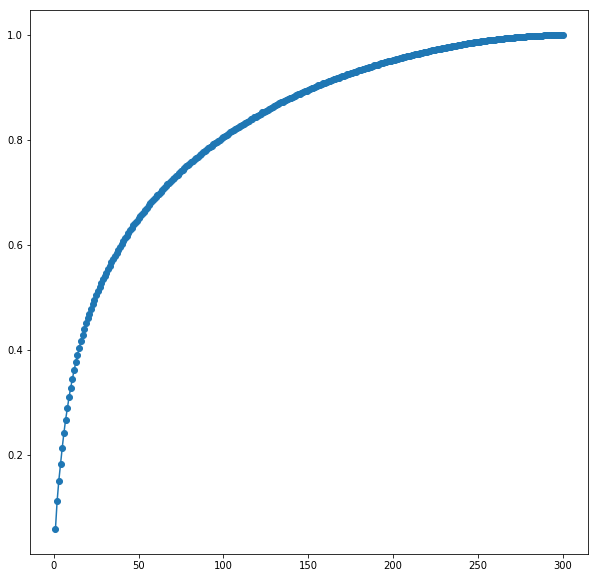

In [11]:
import pandas as pd
import p3_util_plot

if True :
    X_train_pca = p3_util_plot.df_pca_all_plot(pd.DataFrame(X_train), plot=True)

In [15]:
X_train_pca.shape

(4593, 300)

In [680]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

X_train.shape
X_sample = pd.DataFrame(X_train).sample(100)
std_scale = preprocessing.StandardScaler().fit(X_sample)
X_scaled = std_scale.transform(X_sample)
pca = PCA()
X_sample_pca = pca.fit_transform(X_scaled)


In [24]:
import p5_util
filename = "./data/X_train_pca.dump"
p5_util.object_dump(X_train_pca,filename)

print(X_train.shape)

(4593, 300)

In [682]:
X_sample_pca.shape
X_scaled[:,0].std()

1.0

    This curve shows that variance is equaly distributed among all features.
    PCA is based on linear model for variance computation.
    If the model is suspected not having non-linear relations between features, then PCA will not be 
    able to capture variance among data points.

## <font color=blus>1.2 Kernel PCA analysis</font>

    Kernel PCA, computing variance in a largest space, is expected to capture data variance for non-linear 
    data model, means, model in which non-linear relations exists between features.


    This aims to check wether or not there are non linear relations between features based on co-variancy
    criteria.
    
    Function returns the scaled dataset.

In [25]:
n_sample = 5000
X_train.shape[0]
if n_sample > X_train.shape[0] :
    n_sample = X_train.shape[0]
print("Samples from X_train= {}".format(n_sample))

Samples from X_train= 5000


/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]
/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


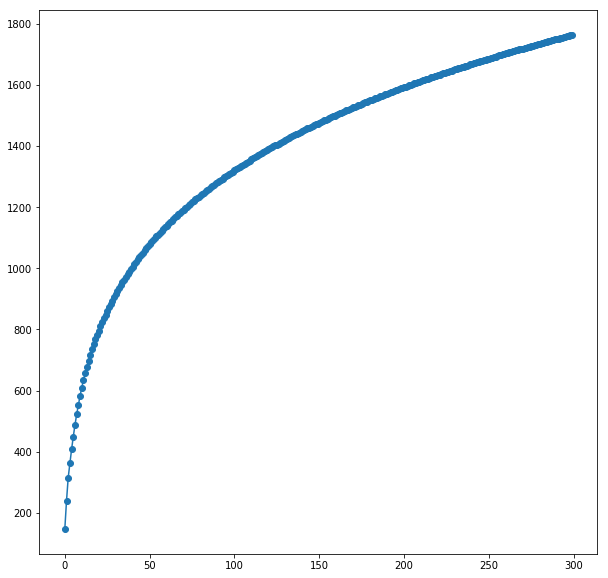

In [19]:
import pandas as pd
import p3_util_plot
#n_sample = 1000
if True :
    X_sample_kpca_rbf = p3_util_plot.df_kpca_all_plot(pd.DataFrame(X_train).sample(n_sample), plot=True, 
                                      kernel_pca= 'rbf')

    Gaussian RBF kernel does not provides a factorial analysis model capturing variancy.
    
    Polynomial kernel is checked with multiple degrees.

In [20]:
dict_kernel_param={'kernel_name':'poly','degree':3}

** Processed components 100/300= 
** Processed components 200/300= 
** Processed components 300/300= 


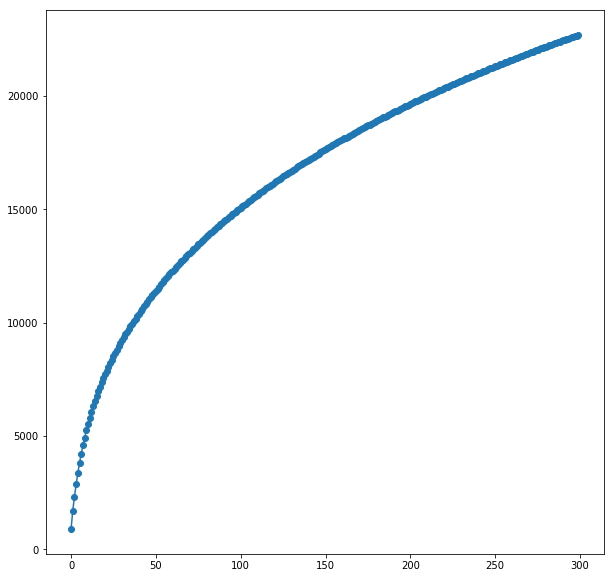

In [21]:
import pandas as pd
import p3_util_plot
#n_sample = 5000
if True :
    X_train_kpca_poly_deg3 = p3_util_plot.df_kpca_all_plot(pd.DataFrame(X_train).sample(n_sample), plot=True, 
                                      kernel_pca= 'poly', dict_kernel_param=dict_kernel_param)

In [28]:
import p5_util
filename = "./data/X_train_kpca_poly_deg3.dump"
p5_util.object_dump(X_train_kpca_poly_deg3,filename)

print(X_train_kpca_poly_deg3.shape)

(4593, 300)


In [26]:
dict_kernel_param={'kernel_name':'poly','degree':5}

In [29]:
X_train.shape

(29651, 100, 300)

** Processed components 100/300= 
** Processed components 200/300= 
** Processed components 300/300= 


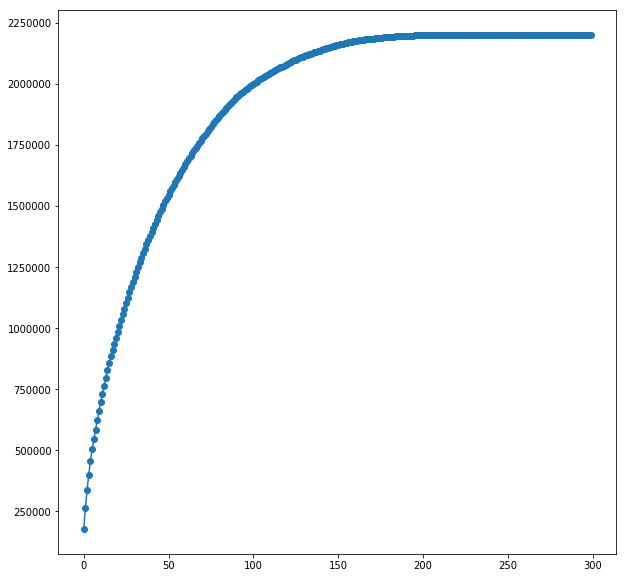

In [35]:
import pandas as pd
import p3_util_plot


if False :
    X_sample_kpca_poly_deg5 = p3_util_plot.df_kpca_all_plot(pd.DataFrame(X_train).sample(n_sample), plot=True, 
                                      dict_kernel_param= dict_kernel_param)
else :
    X_sample_kpca_poly_deg5 = p3_util_plot.df_kpca_all_plot(pd.DataFrame(X_train.reshape((-1, 300))).sample(1000), plot=True, 
                                      dict_kernel_param= dict_kernel_param)
    

#### t-SNE reduction over KernelPCA transformation

In [58]:
print(X_sample_kpca_poly_deg5[:150].shape)
X_sample_kpca_poly_deg5.shape

(150, 300)


(1000, 300)

In [69]:
#import p5_util_plot
import p5_util

dict_tsne_result_part \
= p5_util.tsne_X_dim_process_perplexity(pd.DataFrame(X_sample_kpca_poly_deg5), 
list_tsne_perplexity=[5,10,20,30,40], tsne_iter=6000, dim=3)

tSNE perplexity : 5/50 ...
tSNE perplexity : 10/50 ...
tSNE perplexity : 20/50 ...
tSNE perplexity : 30/50 ...
tSNE perplexity : 40/50 ...


<IPython.core.display.Javascript object>


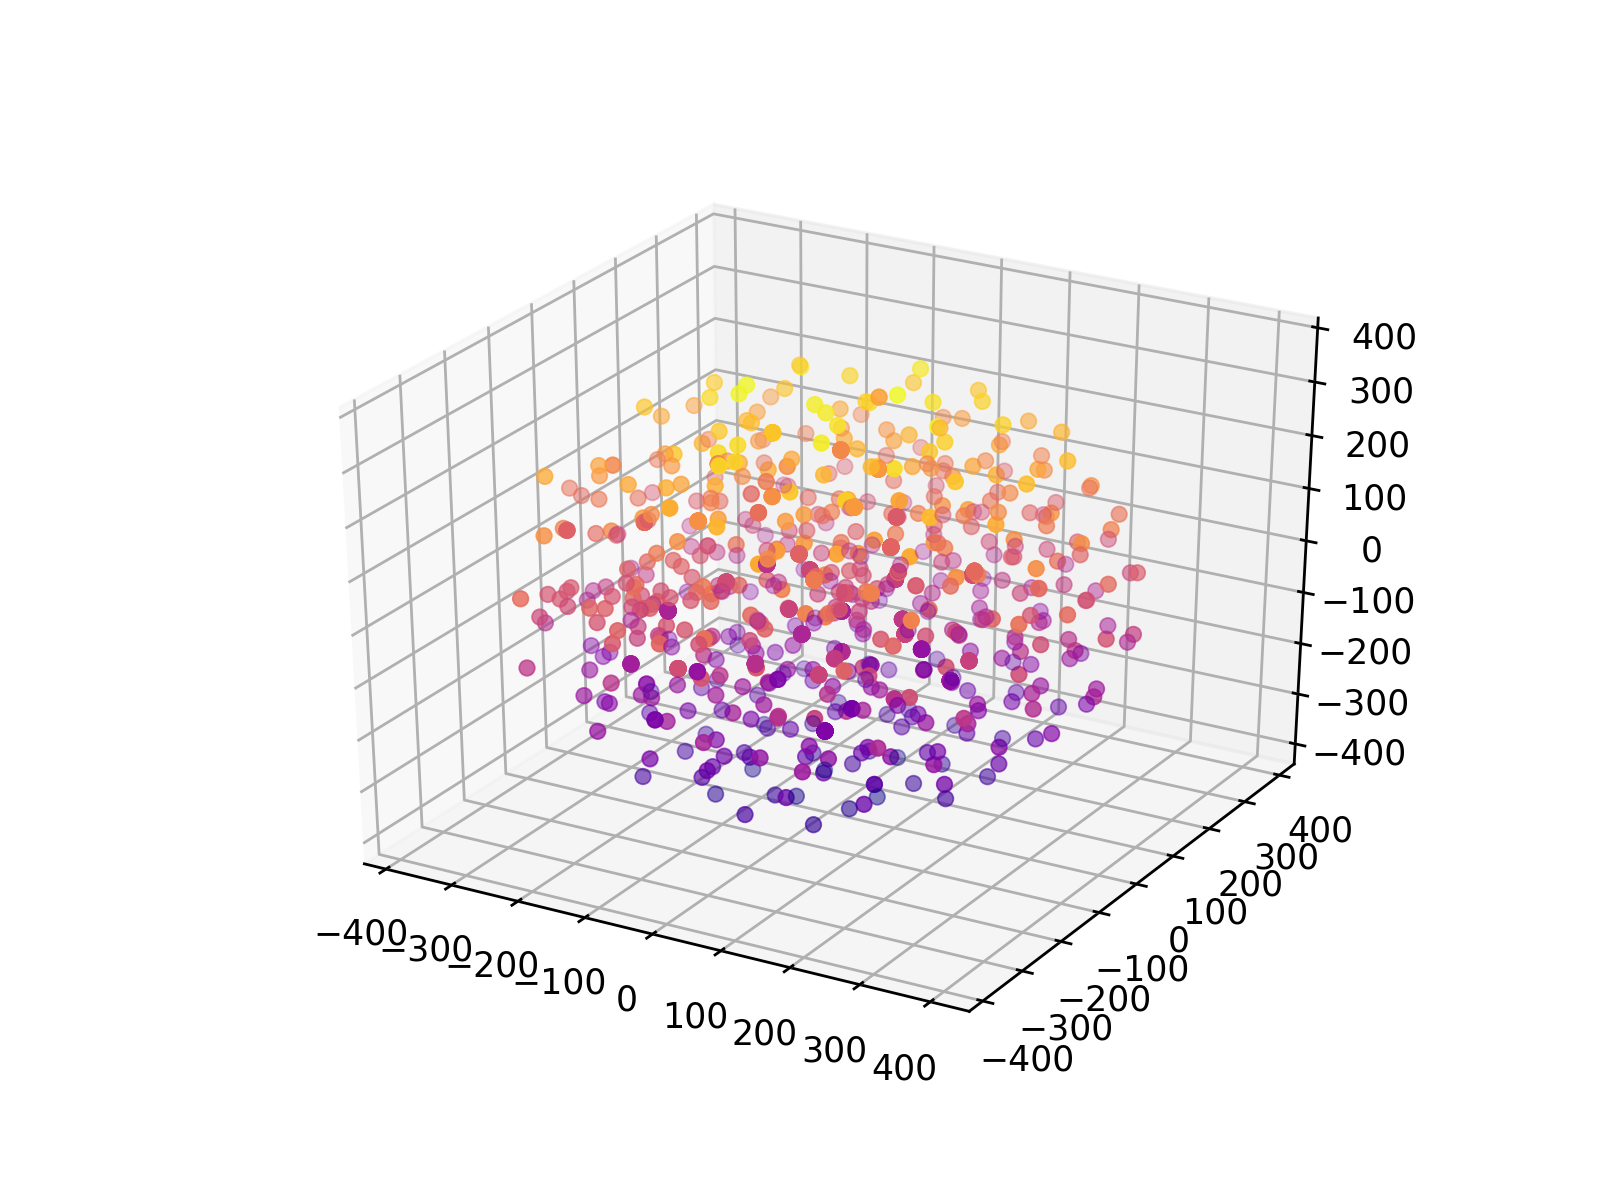

In [70]:
%matplotlib notebook
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
X = dict_tsne_result_part[5]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


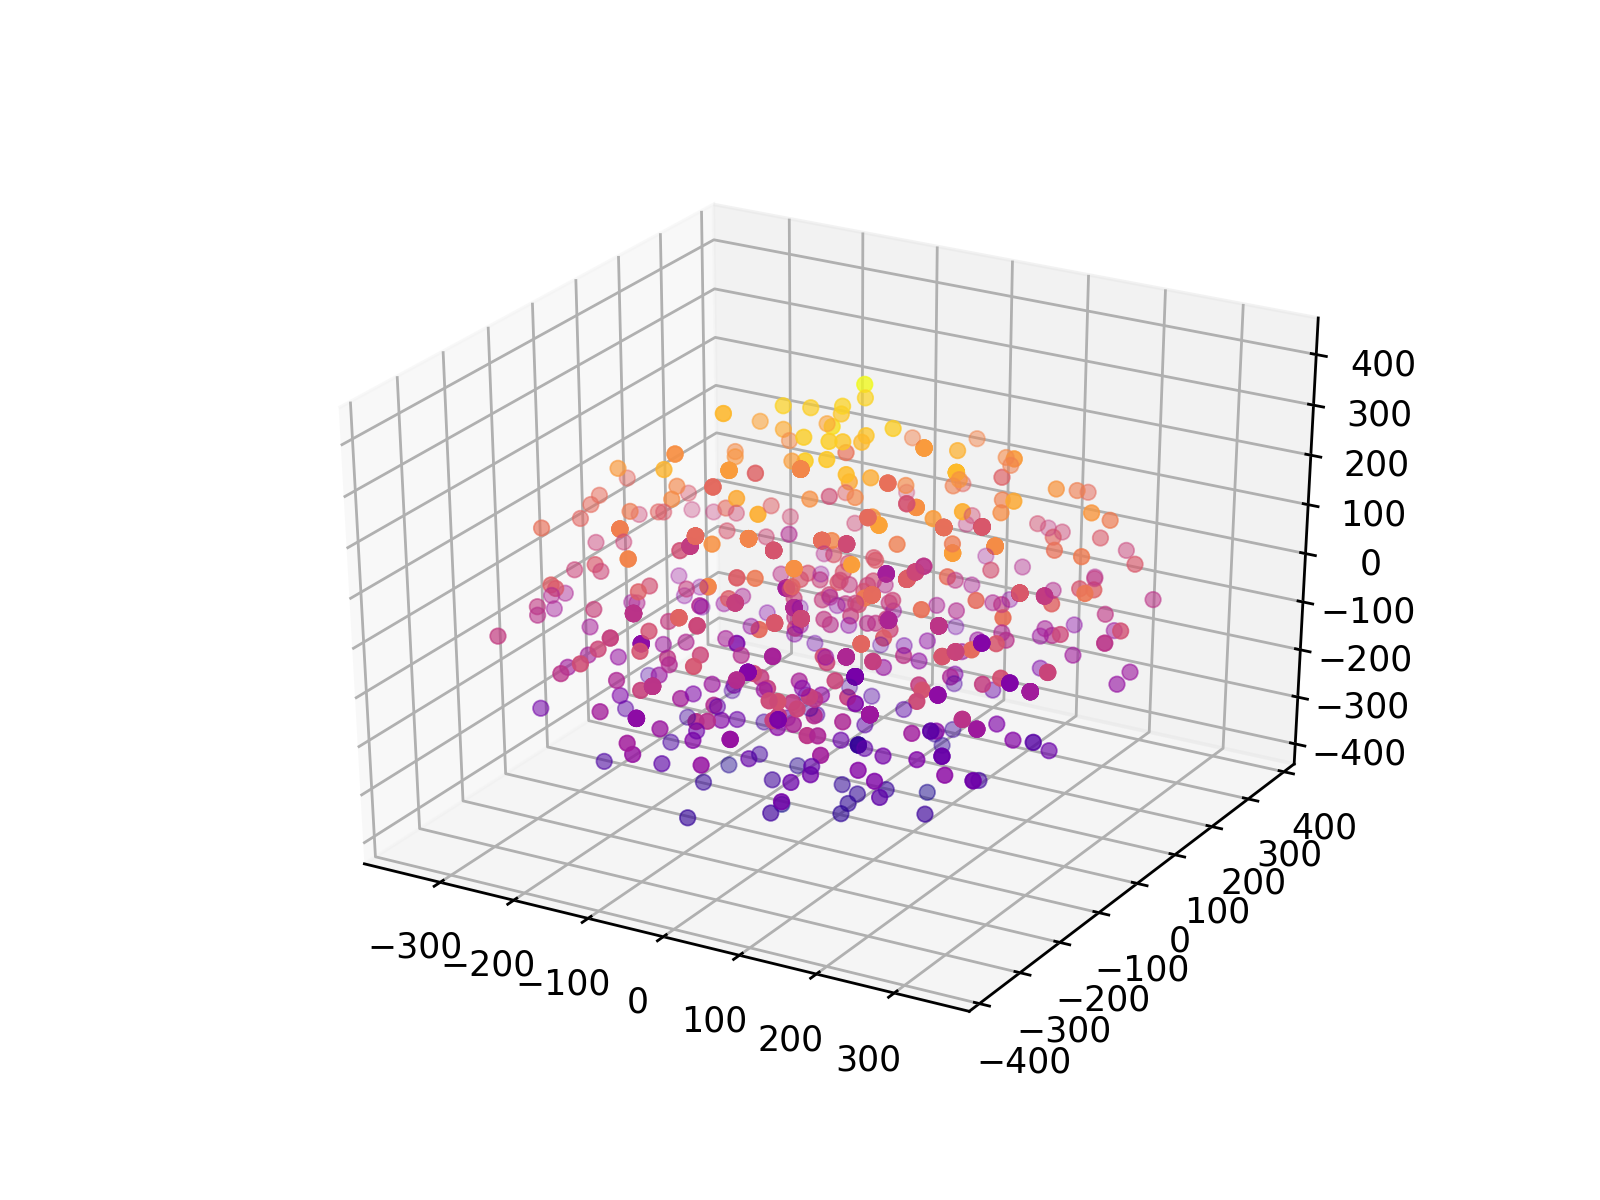

In [71]:
%matplotlib notebook
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
X = dict_tsne_result_part[10]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


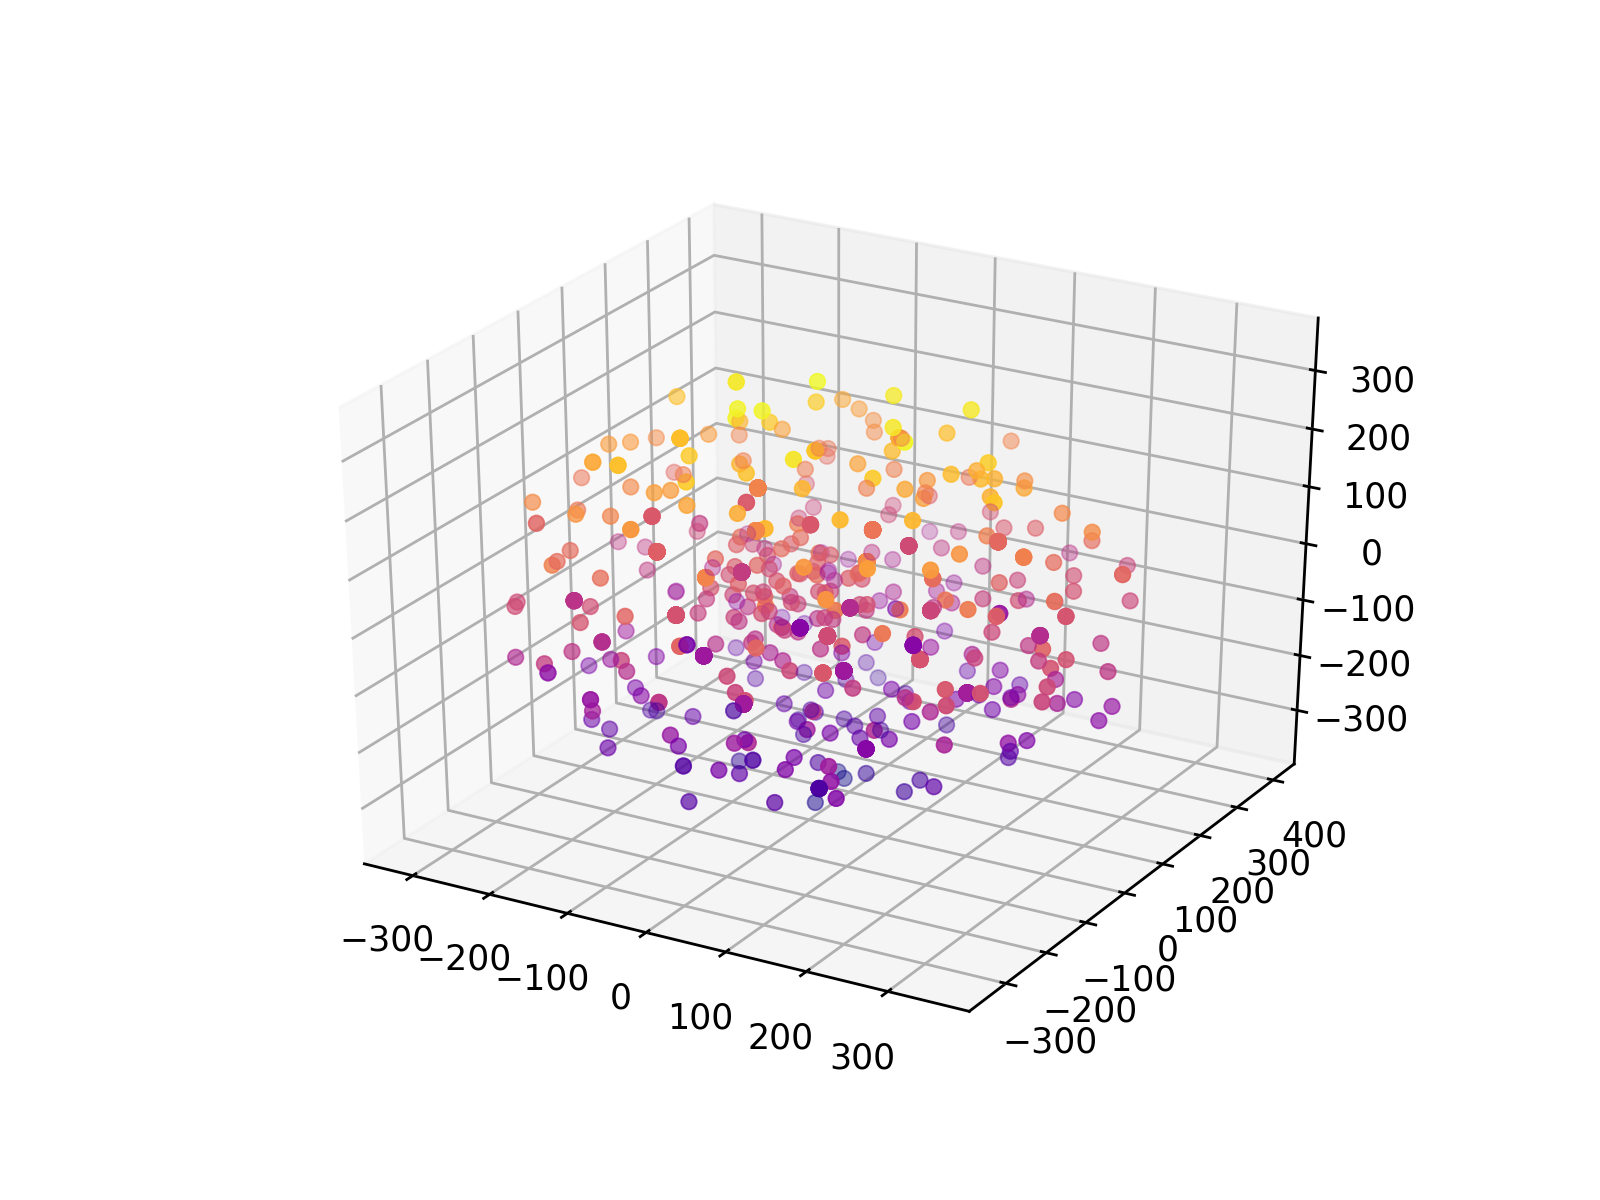

In [72]:
%matplotlib notebook
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
X = dict_tsne_result_part[20]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

In [75]:
#import p5_util_plot
import p5_util

dict_tsne_result_part \
= p5_util.tsne_X_dim_process_perplexity(pd.DataFrame(X_sample_kpca_poly_deg5), 
list_tsne_perplexity=[25], tsne_iter=10000, dim=3)

tSNE perplexity : 25/50 ...


<IPython.core.display.Javascript object>


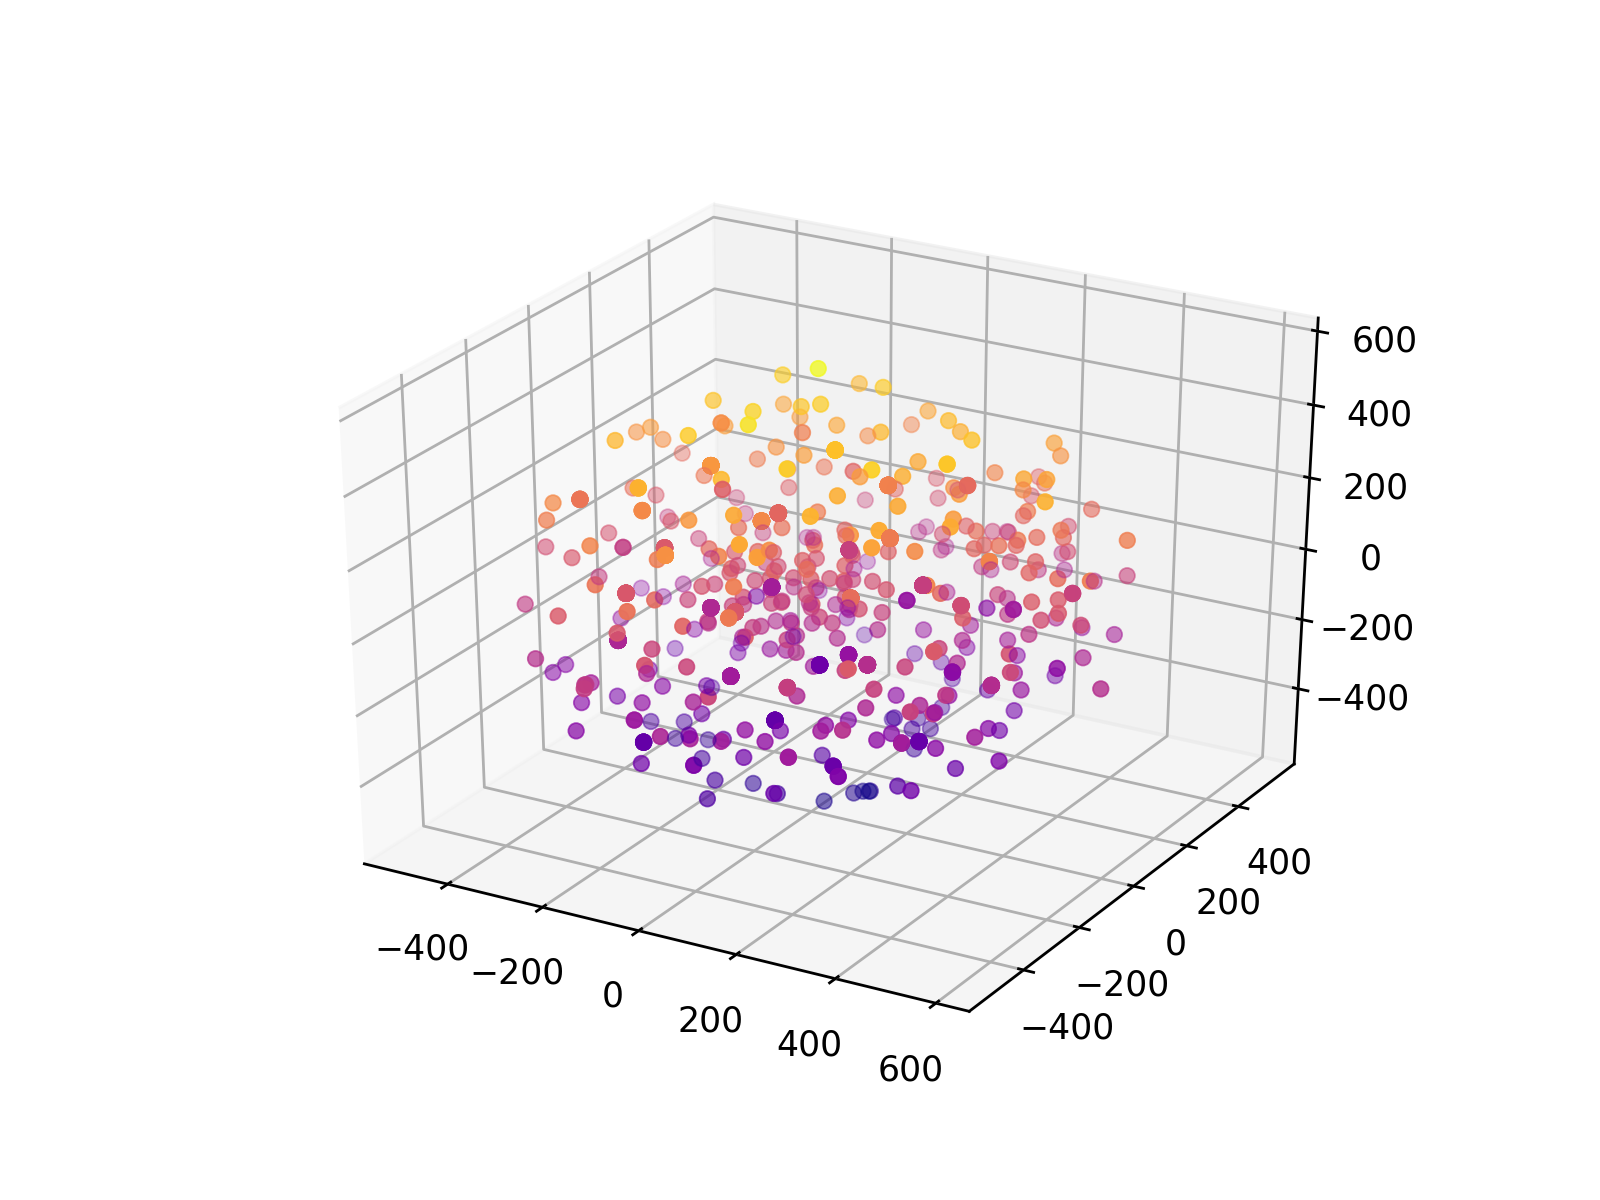

In [76]:
%matplotlib notebook
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
X = dict_tsne_result_part[25]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


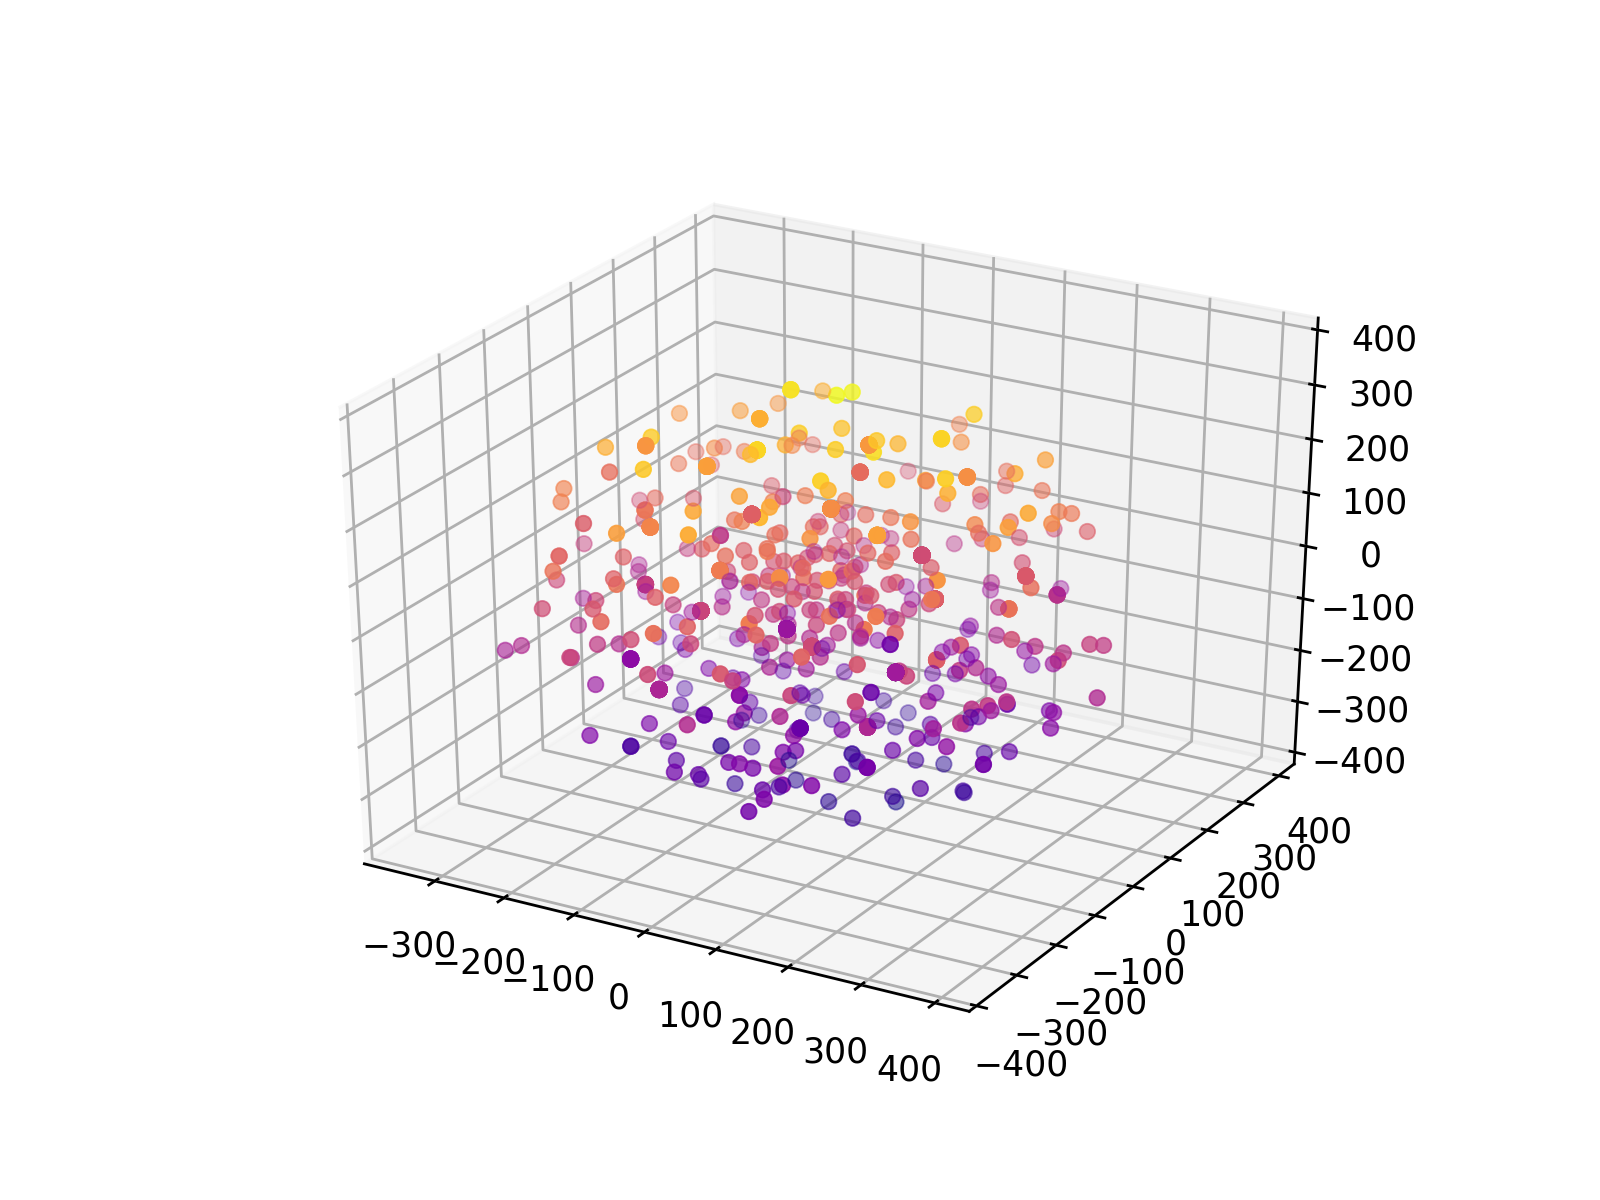

In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
X = dict_tsne_result_part[30]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


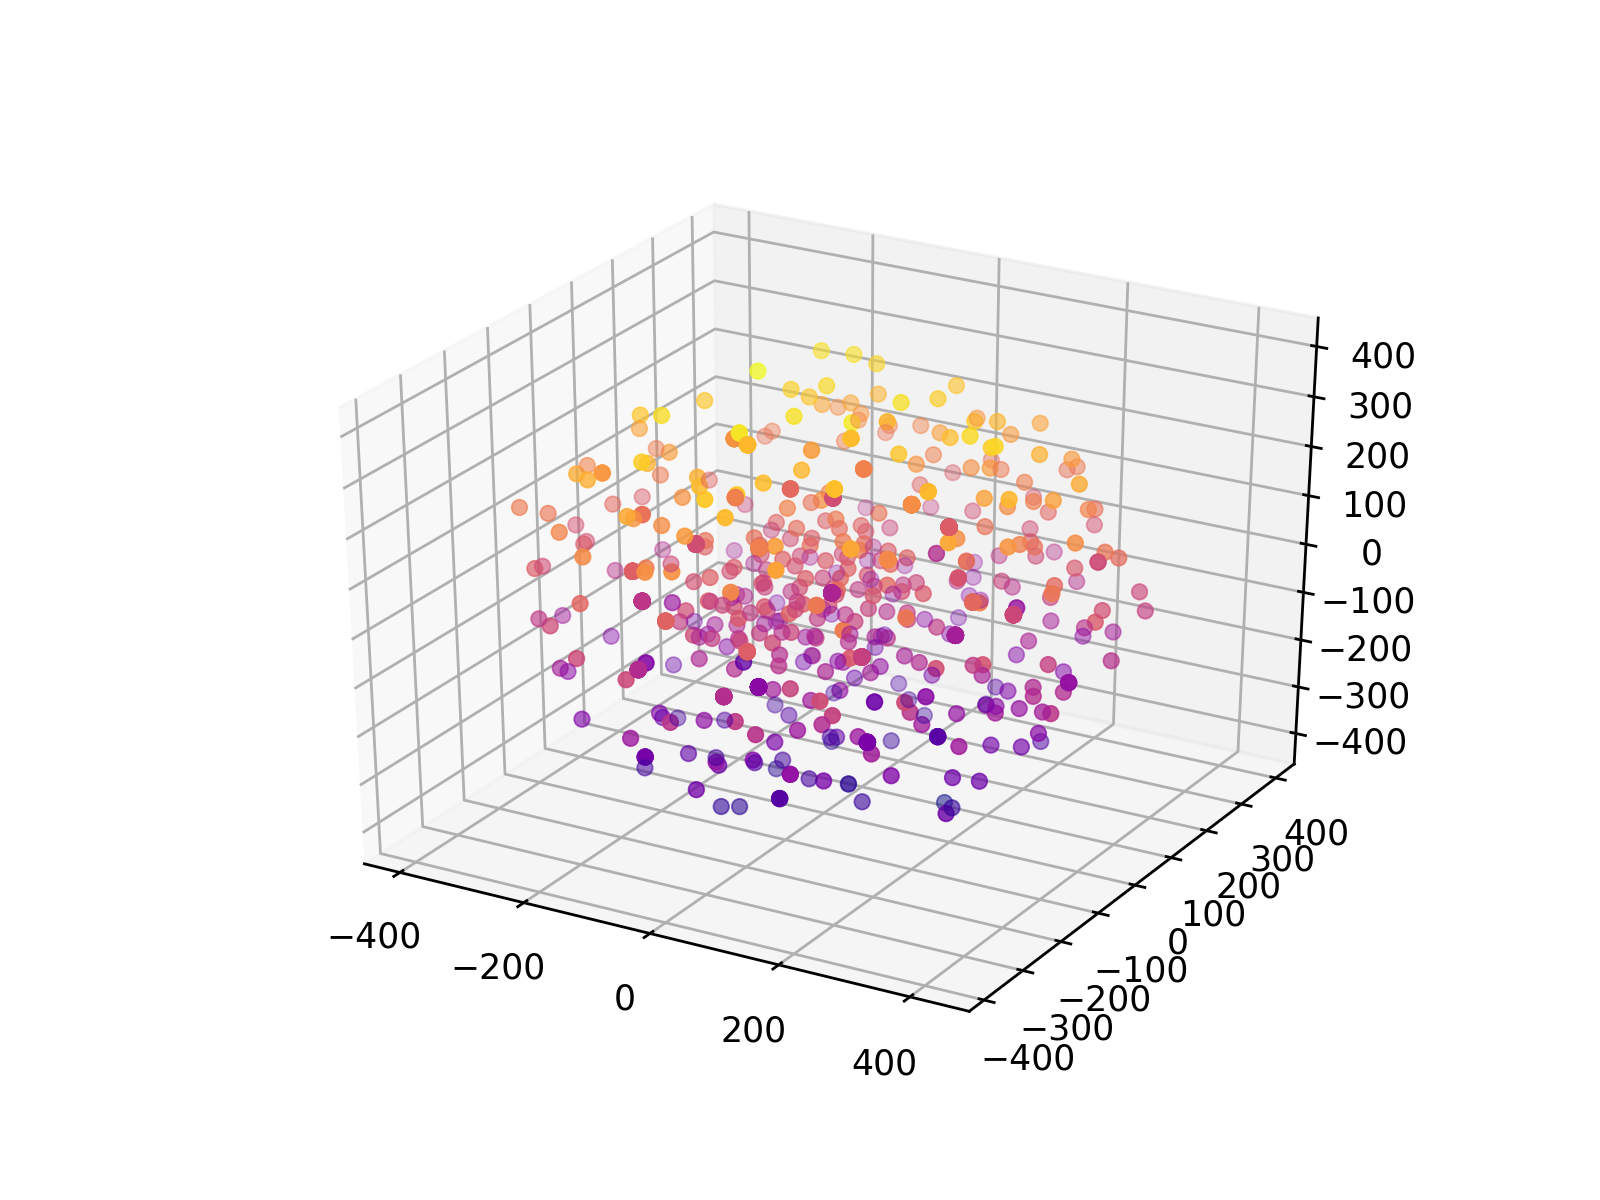

In [74]:
%matplotlib notebook
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
X = dict_tsne_result_part[40]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

#### t-SNE reduction without transformation

In [47]:
#import p5_util_plot
import p5_util

dict_tsne_result_part \
= p5_util.tsne_X_dim_process_perplexity(pd.DataFrame(X_train.reshape((-1, 300))).sample(1000), 
list_tsne_perplexity=[10,20,30,40], tsne_iter=3000, dim=3)

tSNE perplexity : 10/50 ...
tSNE perplexity : 20/50 ...
tSNE perplexity : 30/50 ...
tSNE perplexity : 40/50 ...


In [48]:
dict_tsne_result_part.keys()

dict_keys([10, 20, 30, 40])

<IPython.core.display.Javascript object>


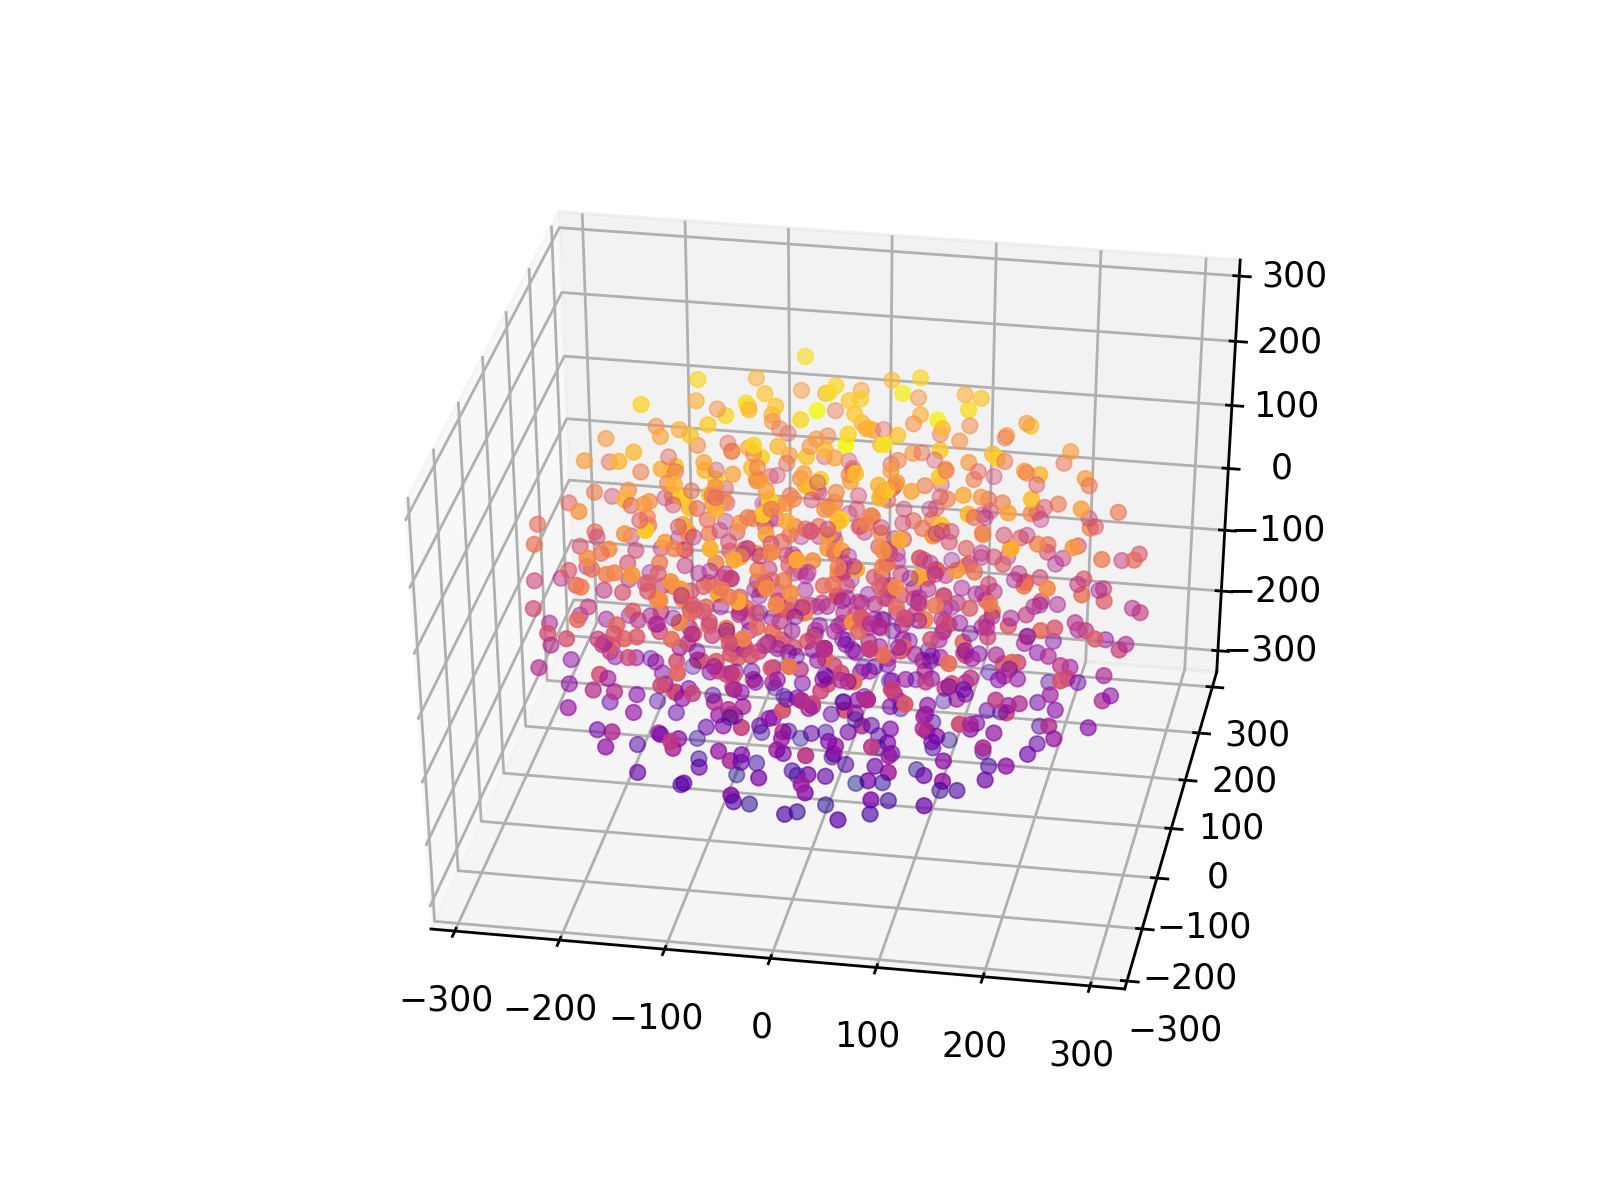

In [49]:
%matplotlib notebook
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
X = dict_tsne_result_part[10]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


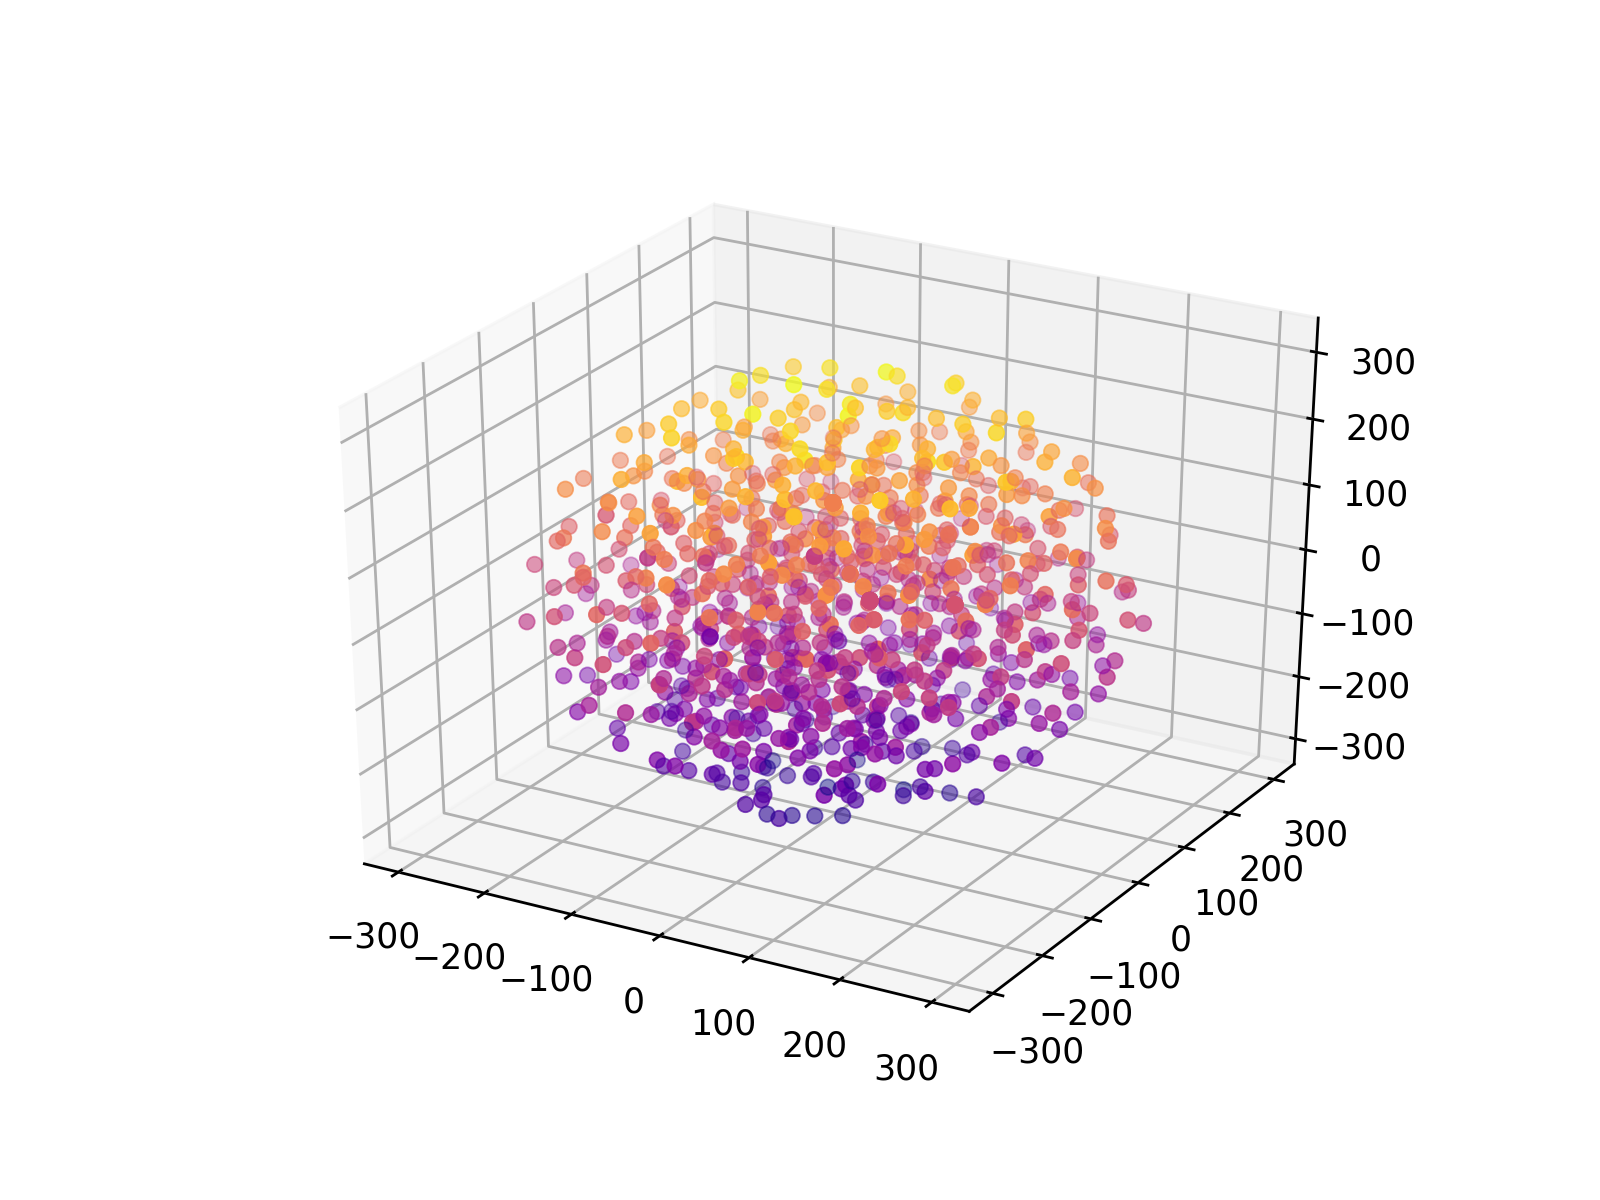

In [50]:
%matplotlib notebook
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
X = dict_tsne_result_part[20]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


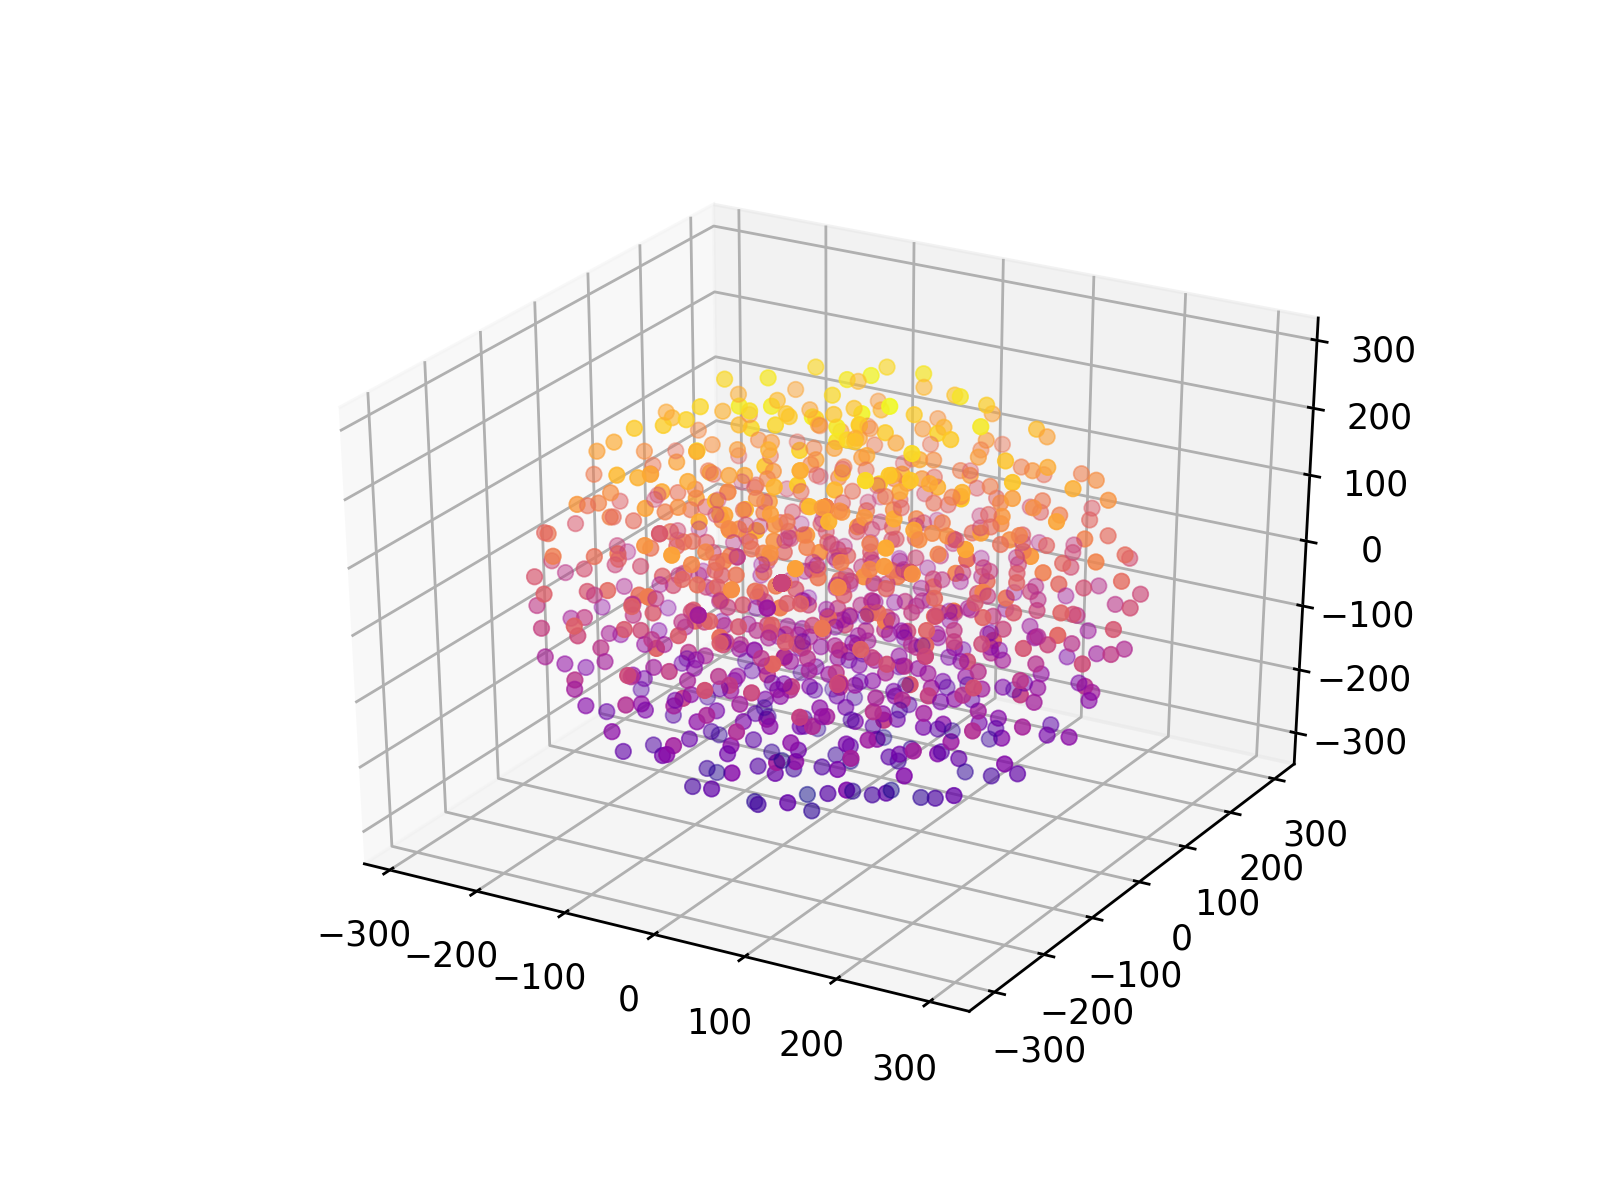

In [51]:
%matplotlib notebook
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
X = dict_tsne_result_part[30]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

<IPython.core.display.Javascript object>


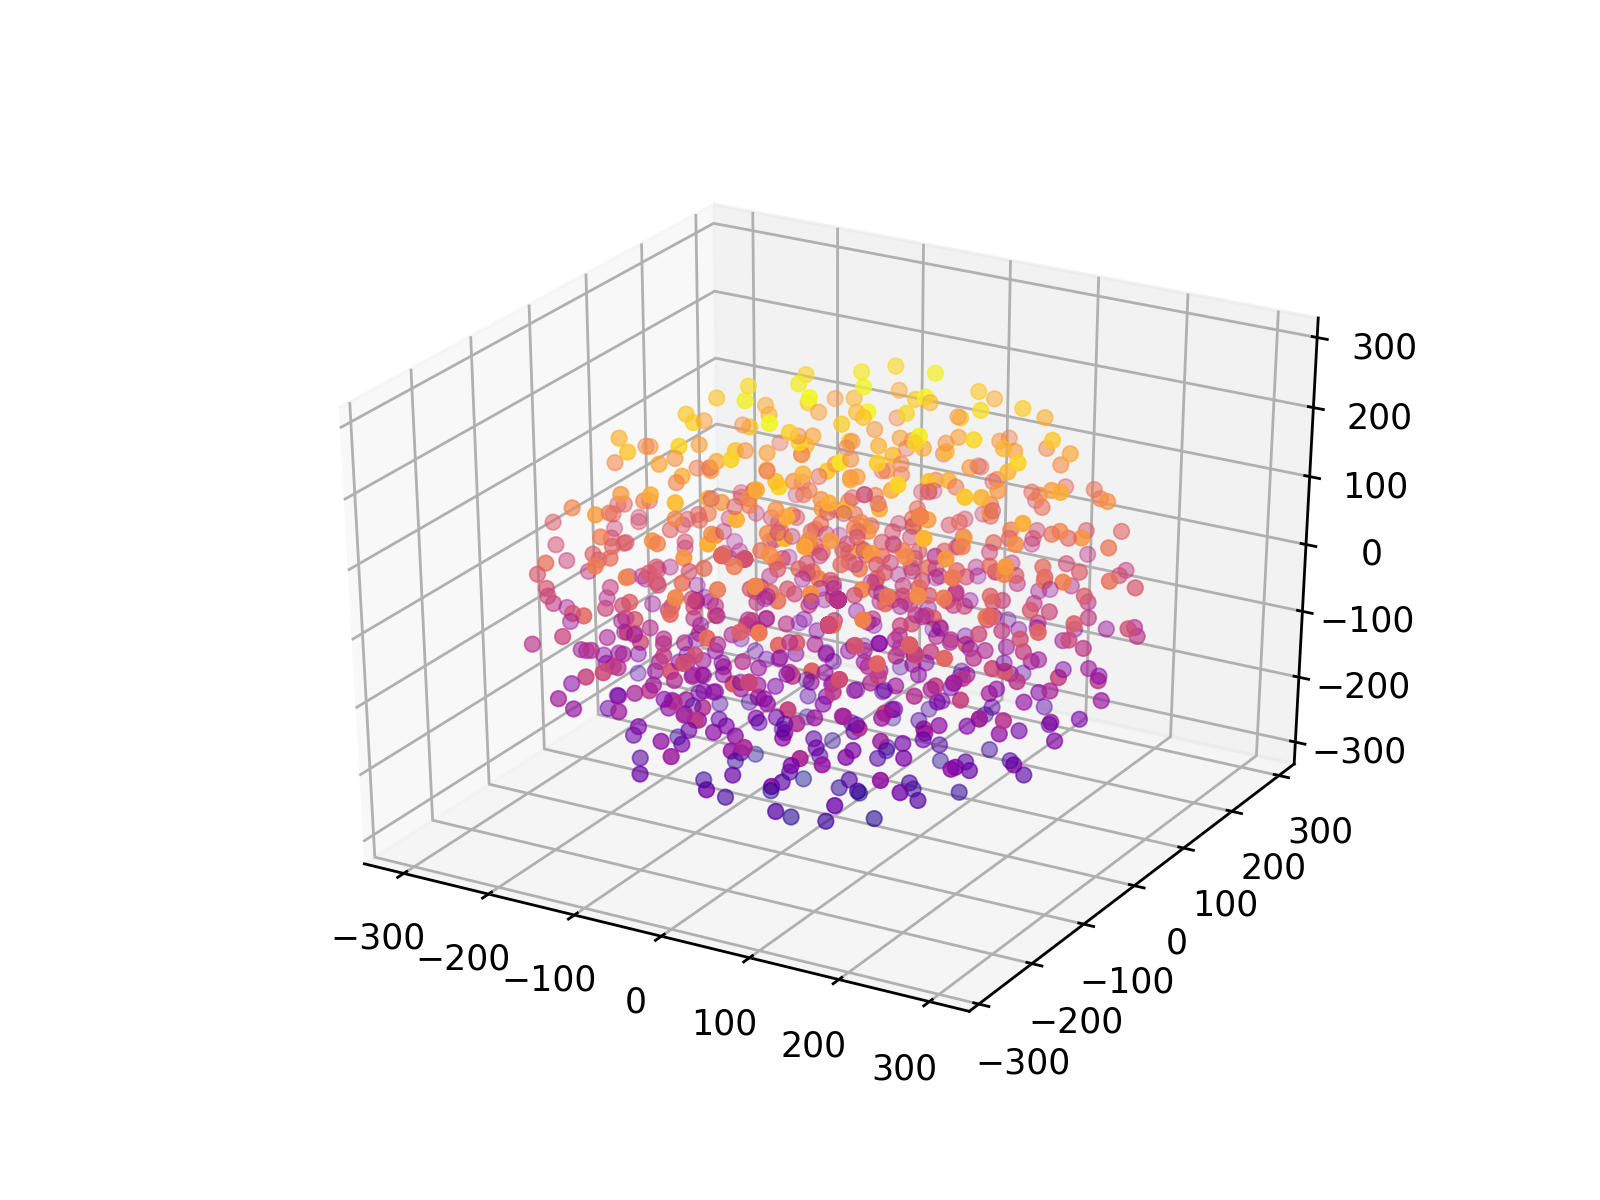

In [52]:
%matplotlib notebook
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
X = dict_tsne_result_part[40]
x= X[:, 0]
y= X[:, 1]
z= X[:, 2]

ax.scatter(x, y, z, c=z, cmap='plasma', linewidth=0.5);

    Build a sample of dataset. 
    
    Factorial analysis based on kernel mode needs huge resources in term of memory.
    

# <font color=blus>2 Binary vectors transformation</font>


    Targets, that are continues values from float type, are converted into classes of integers, such leading to a classification model.
    
    For doing that, y_train_encoded and y_test_encoded are transformed as array of integers, 
    ranging from 0 to 10, leading to 11 classes.

## <font color=blus>2.1 Conversion of targets values to binaries values</font>

In [45]:
y_train_label_vect_bin = dataPreparator_train.vectorValue2BinaryvectorLabel(vector_value=y_train)
y_test_label_vect_bin = dataPreparator_test.vectorValue2BinaryvectorLabel(vector_value=y_test)

In [46]:
print("\nNumber of safe texts for train dataset  = {}".format(len((np.where(y_train_label_vect_bin==0)[0]))))
print("Number of toxics texts for train dataset= {}".format(len((np.where(y_train_label_vect_bin==1)[0]))))

print("\nNumber of safe texts for test dataset  = {}".format(len((np.where(y_test_label_vect_bin==0)[0]))))
print("Number of toxics texts for test dataset= {}".format(len((np.where(y_test_label_vect_bin==1)[0]))))


Number of safe texts for train dataset  = 9382
Number of toxics texts for train dataset= 4241

Number of safe texts for test dataset  = 9367
Number of toxics texts for test dataset= 4249


In [48]:
9382+4241, y_train.shape, 9367+4249, y_test.shape

(13623, (13623,), 13616, (13616,))

`y_train` and `y_test` are vectors with float values ranging from `0.0` to `1.0`. 

`decimal_count` is the value allowing to take into account the number of decimals when converting continuous values into classes.

As a result, `y_train_label` and `y_test_label` are `[N x Classes]` matrix issued from One-hot-encoding were position of value `1` in a column indicates the class value.



In [36]:
y_train_label_vect_bin.shape, 10515+4485, 10504+4496, y_test_label_vect_bin.shape, X_train.shape

((15000,), 15000, 15000, (15000,), (13623, 300))

## <font color=blus>2.2 Dataset standardization</font>

Standard deviation and mean is checked against a random index from standardized `X_train_std` dataset.

In [49]:
X_train.shape, X_test.shape

((13623, 300), (13616, 300))

In [50]:
import p9_util
import random
if False :
    scaler, X_train_std, X_test_std = p9_util.data_scale(X_train, X_test, scaler_name='Standard')
else :

    X_train_std = X_train.copy()
    X_test_std = X_test.copy()

In [51]:
X_train_std.shape, X_test_std.shape

((13623, 300), (13616, 300))

In [52]:
random_index = random.randint(0, X_train_std.shape[1])
print("\n Random index= {} / Train Std devition={} / Train Mean= {}".format(random_index, round(X_train_std[:,random_index].std()),round(X_train_std[:,random_index].mean())))
random_index = random.randint(0, X_test_std.shape[1])
print(" Random index= {} / Test Std devition= {} / Test Mean = {}".format(random_index, round(X_train_std[:,random_index].std()),round(X_train_std[:,random_index].mean())))
print("")


 Random index= 71 / Train Std devition=0.0 / Train Mean= 0.0
 Random index= 284 / Test Std devition= 0.0 / Test Mean = -0.0



## <font color=blus>2.3 Sampling of dataset</font>

`X_train_std` and `X_test_std` are converted into dataframes. 

While doing so, random sampling of `n_sample` observations is extracted from train dataframe along with indexes.

Indexes allows to select targets matching with samples extracted from `X_train` and `X_test`.

Note that also `n_sample` cases from test dataset are also extracted.

In [86]:
n_sampling=10000
n_sampling, X_train_std.shape[0]

(10000, 13623)

In [87]:
import pandas as pd
print("\nNumber of samples= {}".format(n_sampling))
if n_sampling >0 :
    if n_sampling < X_train_std.shape[0] :
        df_train_sample = pd.DataFrame(X_train_std).sample(n_sampling)

        y_train_label_vect_bin_sample = y_train_label_vect_bin[df_train_sample.index]

        df_test_sample = pd.DataFrame(X_test_std).sample(n_sampling)
        y_test_label_vect_bin_sample = y_test_label_vect_bin[df_test_sample.index]
    else :
        df_train_sample = pd.DataFrame(X_train_std)
        df_test_sample = pd.DataFrame(X_test_std)
        
        y_train_label_vect_bin_sample = y_train_label_vect_bin.copy()
        y_test_label_vect_bin_sample = y_test_label_vect_bin.copy()
else :
    df_train_sample = pd.DataFrame(X_train_std)
    y_train_label_vect_bin_sample = y_train_label_vect_bin.copy()

    df_test_sample = pd.DataFrame(X_test_std)
    y_test_label_vect_bin_sample = y_test_label_vect_bin.copy()
    
print("")    
print("Train dataset shape= {}".format(df_train_sample.shape))
print("Train target shape=  {}".format(y_train_label_vect_bin_sample.shape))
print("")
print("Test dataset shape= {}".format(df_test_sample.shape))
print("Test target shape=  {}".format(y_test_label_vect_bin_sample.shape))


Number of samples= 10000

Train dataset shape= (10000, 300)
Train target shape=  (10000,)

Test dataset shape= (10000, 300)
Test target shape=  (10000,)


In [88]:
print("\nNumber of safe texts for train sample  = {}".format(len((np.where(y_train_label_vect_bin_sample==0)[0]))))
print("Number of toxics texts for train sample= {}".format(len((np.where(y_train_label_vect_bin_sample==1)[0]))))

print("\nNumber of safe texts for test sample  = {}".format(len((np.where(y_test_label_vect_bin_sample==0)[0]))))
print("Number of toxics texts for test sample= {}".format(len((np.where(y_test_label_vect_bin_sample==1)[0]))))


Number of safe texts for train sample  = 6911
Number of toxics texts for train sample= 3089

Number of safe texts for test sample  = 6865
Number of toxics texts for test sample= 3135


## <font color=blus>2.4 Gram matrix</font>

In [576]:
from sklearn.metrics.pairwise import rbf_kernel
dim=500
gamma = 1.e-6
kmatrix = rbf_kernel(X_train_std[:dim,:], gamma=gamma)
kmatrix.min(), kmatrix.max()

(0.9966542268334373, 1.0)

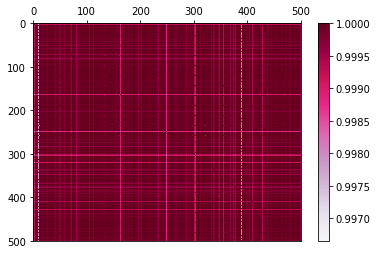

In [577]:
import matplotlib
import matplotlib.pyplot as plt

# dessiner la matrice
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# définir les axes
plt.xlim([0, dim])
plt.ylim([0, dim])

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

In [546]:
from sklearn import metrics
X_train_gram = X_train_std[:500].copy()
kmatrix = metrics.pairwise.polynomial_kernel(X_train_gram, degree=5)
kmatrix.shape

(500, 500)

In [547]:
kmatrix.min(), kmatrix.max()

(0.27617652107970186, 4456088.825441421)

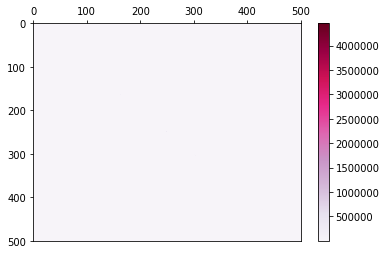

In [548]:
import matplotlib
import matplotlib.pyplot as plt

# dessiner la matrice
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# définir les axes
plt.xlim([0, X_train_gram.shape[0]])
plt.ylim([0, X_train_gram.shape[0]])

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

# <font color=blus>3. Binary Classification</font>

## <font color=blus>3.0 Binary Classifier with PCA</font>

In [89]:
from sklearn import decomposition

n_components = df_train_sample.shape[1]
pca = decomposition.KernelPCA(n_components=n_components)
pca.get_params()

{'alpha': 1.0,
 'coef0': 1,
 'copy_X': True,
 'degree': 3,
 'eigen_solver': 'auto',
 'fit_inverse_transform': False,
 'gamma': None,
 'kernel': 'linear',
 'kernel_params': None,
 'max_iter': None,
 'n_components': 300,
 'n_jobs': None,
 'random_state': None,
 'remove_zero_eig': False,
 'tol': 0}

In [90]:
import p5_util

X_train_sample = pca.fit_transform(df_train_sample.values)
X_test_sample  = pca.transform(df_test_sample.values)
print(X_train_sample.shape)
print(X_test_sample.shape)

filename_train = "./data/Xy_train_sample_bin_pca_"+str(n_sample)+".dump"
filename_test  = "./data/Xy_test_sample_bin_pca_"+str(n_sample)+".dump"

p5_util.object_dump((X_train_sample,y_train_label_vect_bin_sample), filename_train )
p5_util.object_dump((X_test_sample, y_test_label_vect_bin_sample), filename_test )

if False :
    (X_train_sample,y_train_label_vect_bin_sample) = p5_util.object_load(filename_train )
    (X_test_sample, y_test_label_vect_bin_sample)  = p5_util.object_load(filename_test )

print("X_train sample shape = {}".format(X_train_sample.shape))
print("y_train sample shape = {}".format(y_train_label_vect_bin_sample.shape))
print("X_test sample shape = {}".format(X_test_sample.shape))
print("y_test sample shape = {}".format(y_test_label_vect_bin_sample.shape))

print("")
print("Number of safe texts  = {}".format(len(np.where(y_test_label_vect_bin_sample==0)[0])))
print("Number of toxics texts= {}".format(len(np.where(y_test_label_vect_bin_sample==1)[0])))

(10000, 300)
(10000, 300)
X_train sample shape = (10000, 300)
y_train sample shape = (10000,)
X_test sample shape = (10000, 300)
y_test sample shape = (10000,)

Number of safe texts  = 6865
Number of toxics texts= 3135


In [118]:
if False :
    X_train_sample.shape
    factor = X_train_sample.shape[0]//3
    factor
    X_test_sample_reduced = X_test_sample[:factor]
    y_test_label_vect_bin_sample_reduced = y_test_label_vect_bin_sample[:factor]
else :
    X_test_sample_reduced = X_test_sample.copy()
    y_test_label_vect_bin_sample_reduced = y_test_label_vect_bin_sample.copy()

print(X_test_sample_reduced.shape, y_test_label_vect_bin_sample_reduced.shape)
    

(10000, 300) (10000,)


In [122]:
y_weight=None
y_weight_test=None
class_weights = None

In [129]:
import p9_util
y_weight, class_weights = p9_util.build_classweight_vector(y_train_label_vect_bin_sample)
y_weight_test = p9_util.build_vector_from_classweight(y_test_label_vect_bin_sample_reduced,class_weights)

if True:
    #class_weights[0] = 0.75
    class_weights[1] = 1.8
    print(class_weights)
    y_weight = p9_util.build_vector_from_classweight(y_train_label_vect_bin_sample,class_weights)
    y_weight_test = p9_util.build_vector_from_classweight(y_test_label_vect_bin_sample_reduced,class_weights)


Classes weights = [0.7234843  1.61864681]


Class : 0 Weight=0.7234843003906816
Class : 1 Weight=1.618646811265782

Class : 0 Weight=0.7234843003906816
Class : 1 Weight=1.618646811265782

[0.7234843 1.8      ]
Class : 0 Weight=0.7234843003906816
Class : 1 Weight=1.8

Class : 0 Weight=0.7234843003906816
Class : 1 Weight=1.8



In [130]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim  = 0
higher_dim = 40
dim=(lower_dim,higher_dim)
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced =   X_test_sample_reduced[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)

mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample_reduced, sample_weight=y_weight_test)

print("\nGradient Boosting Classifier: mean accuracy score= {}".format(mean_acc))

y_pred_sample = model.predict(X_test_sample_reduced)


Gradient Boosting Classifier: mean accuracy score= 0.68470695581909


[0, 1]

Confusion matrix for all classes : 

[[4784 2081]
 [1022 2113]]

Normalized confusion matrix
[[0.69686817 0.30313183]
 [0.32599681 0.67400319]]
Confusion matrix, without normalization
[[4784 2081]
 [1022 2113]]

TP rate = [0.         0.67400319 1.        ]
FP rate = [0.         0.30313183 1.        ]


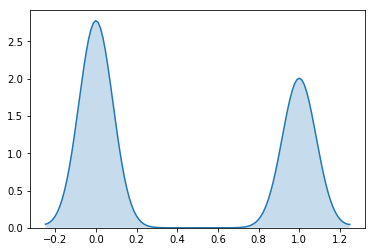

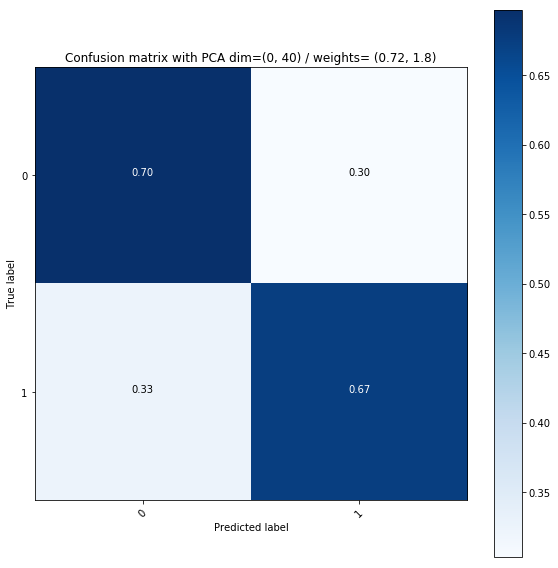

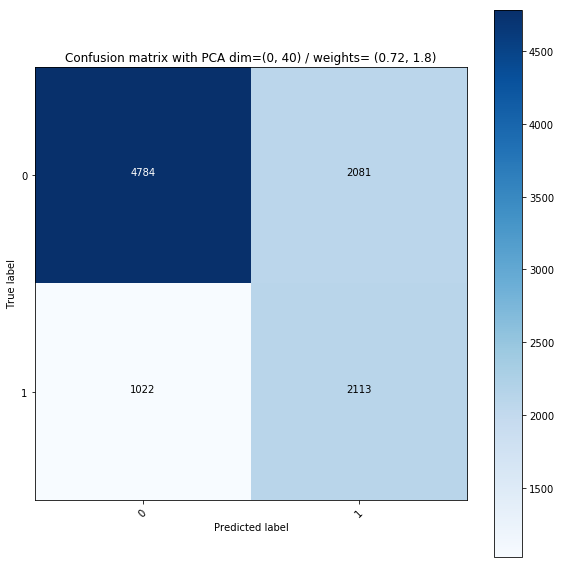

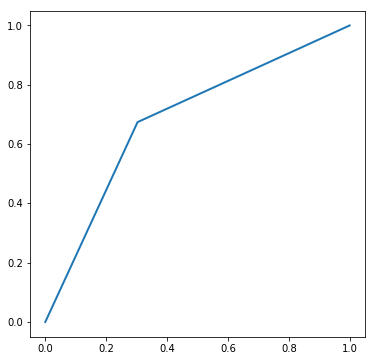

In [131]:
if class_weights is None :
    pass
else :
    class_weights = (round(class_weights[0],2),round(class_weights[1],2))
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample_reduced, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={} / weights= {}".format(dim,class_weights))

[0, 1]

Confusion matrix for all classes : 

[[6238  627]
 [2017 1118]]

Normalized confusion matrix
[[0.90866715 0.09133285]
 [0.64338118 0.35661882]]
Confusion matrix, without normalization
[[6238  627]
 [2017 1118]]

TP rate = [0.         0.35661882 1.        ]
FP rate = [0.         0.09133285 1.        ]


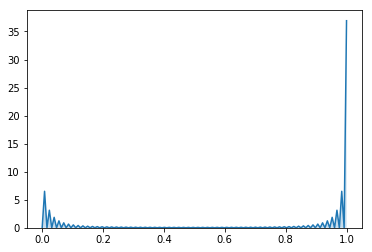

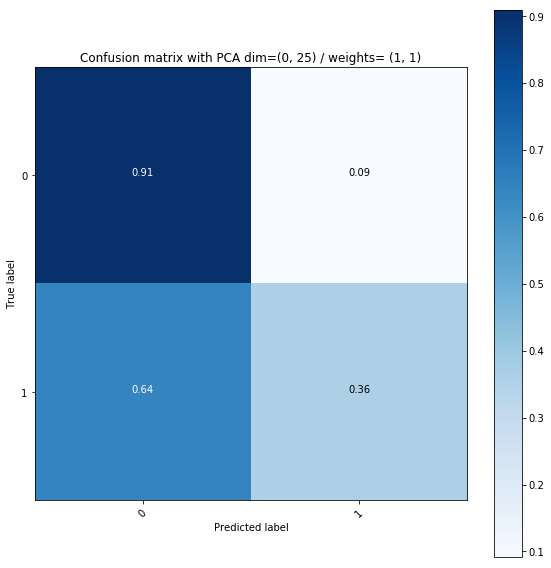

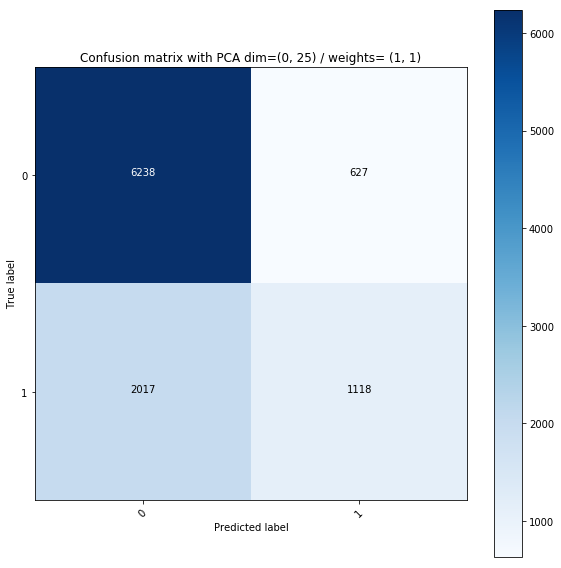

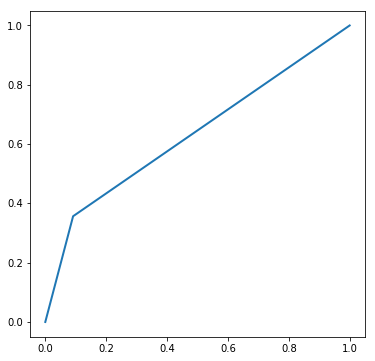

In [93]:
if class_weights is None :
    classa_weights = (1,1)
else :
    class_weights = (round(class_weights[0],2),round(class_weights[1],2))
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={} / weights= {}".format(dim,class_weights))

[0, 1]

Confusion matrix for all classes : 

[[2495  957]
 [ 544 1004]]

Normalized confusion matrix
[[0.72276941 0.27723059]
 [0.35142119 0.64857881]]
Confusion matrix, without normalization
[[2495  957]
 [ 544 1004]]

TP rate = [0.         0.64857881 1.        ]
FP rate = [0.         0.27723059 1.        ]


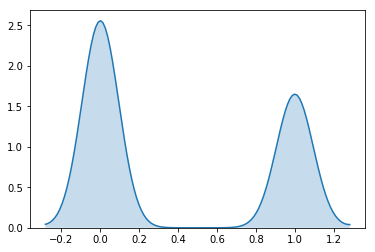

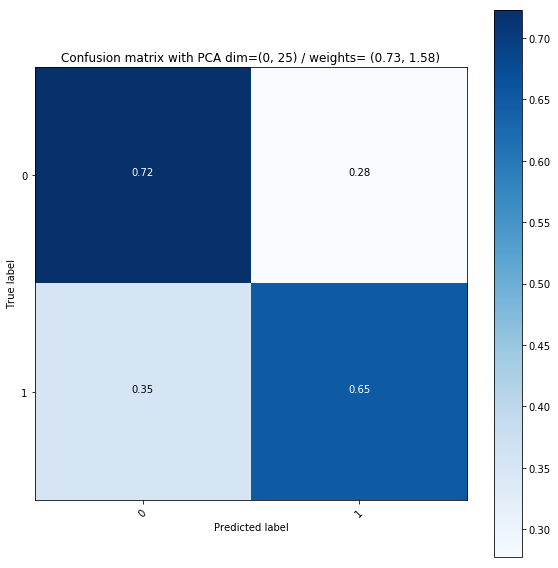

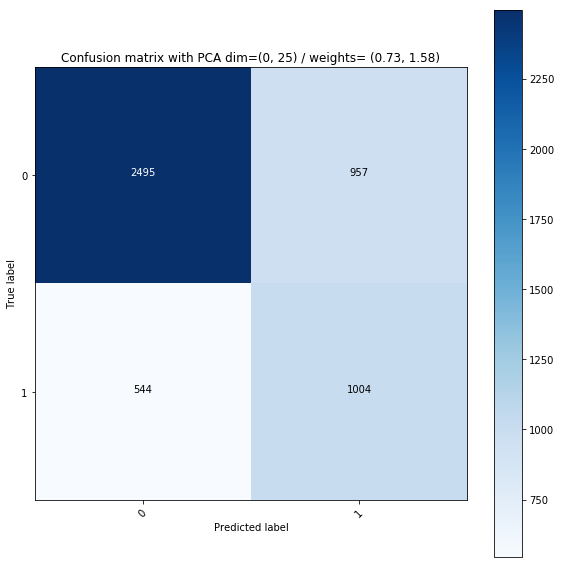

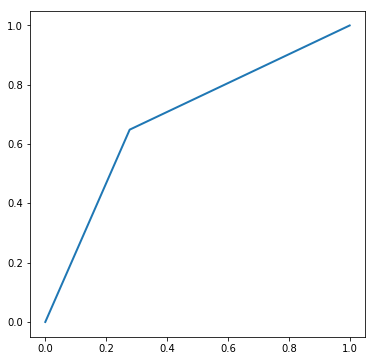

In [77]:
if class_weights is None :
    class_weights = (1,1)
else :
    class_weights = (round(class_weights[0],2),round(class_weights[1],2))
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={} / weights= {}".format(dim,class_weights))

[0, 1]

Confusion matrix for all classes : 

[[976 106]
 [298 143]]

Normalized confusion matrix
[[0.90203327 0.09796673]
 [0.67573696 0.32426304]]
Confusion matrix, without normalization
[[976 106]
 [298 143]]

TP rate = [0.         0.32426304 1.        ]
FP rate = [0.         0.09796673 1.        ]


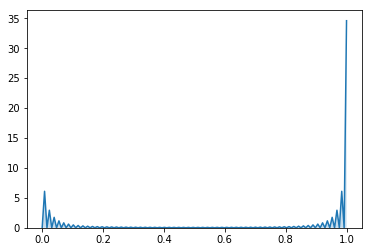

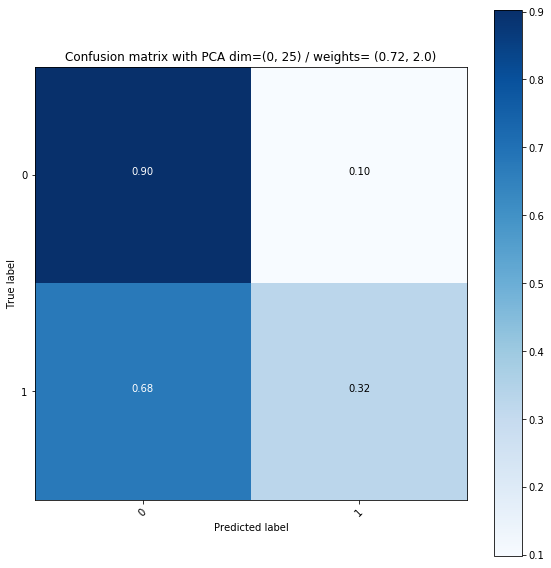

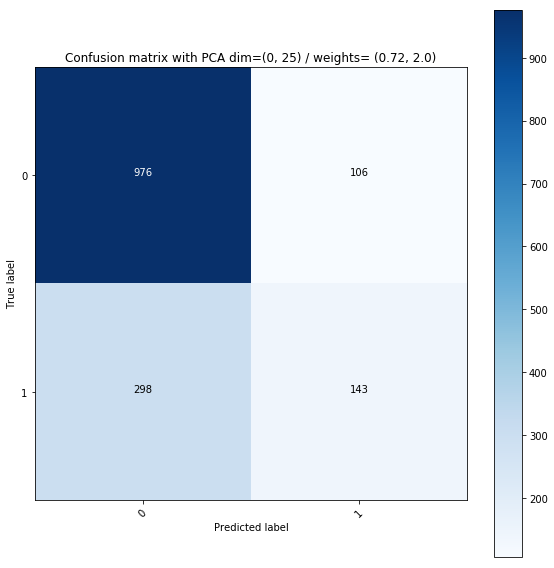

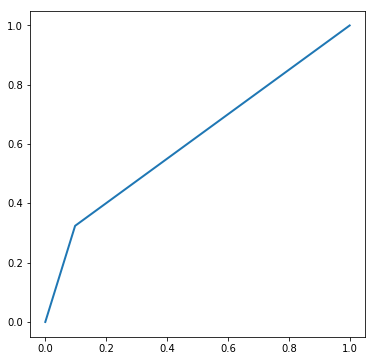

In [41]:
class_weights = (round(class_weights[0],2),round(class_weights[1],2))
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={} / weights= {}".format(dim,class_weights))

[0, 1]

Confusion matrix for all classes : 

[[749 340]
 [158 284]]

Normalized confusion matrix
[[0.68778696 0.31221304]
 [0.35746606 0.64253394]]
Confusion matrix, without normalization
[[749 340]
 [158 284]]

TP rate = [0.         0.64253394 1.        ]
FP rate = [0.         0.31221304 1.        ]


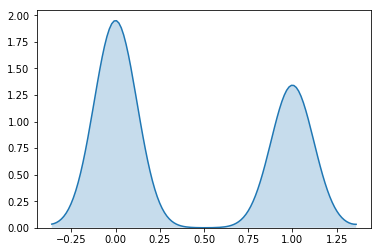

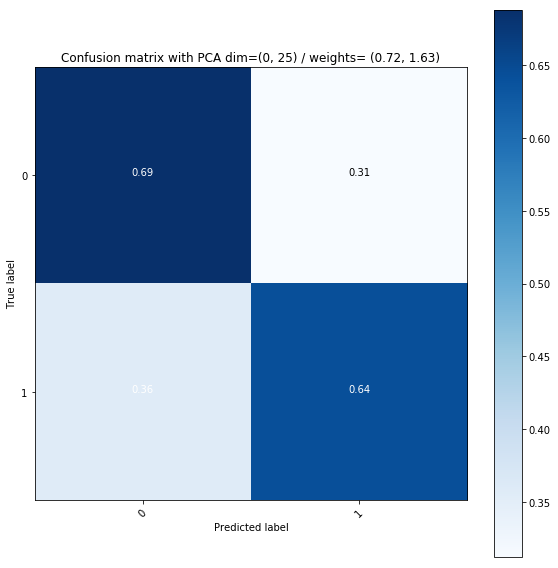

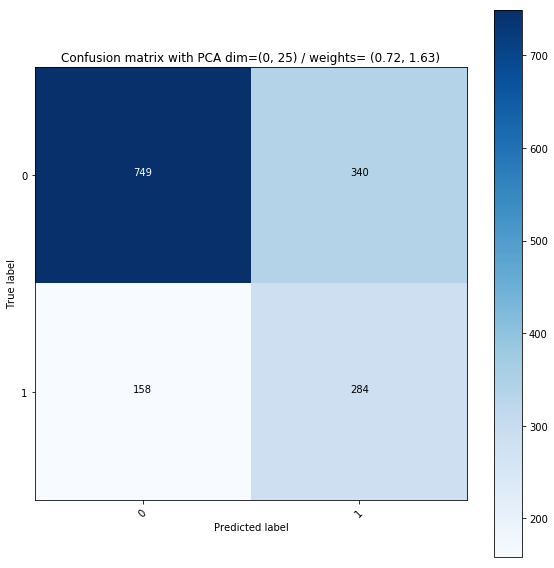

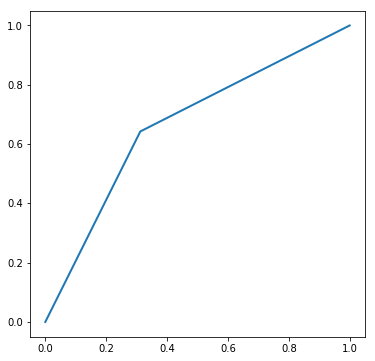

In [107]:
class_weights = (round(class_weights[0],2),round(class_weights[1],2))
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={} / weights= {}".format(dim,class_weights))

/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0, 1]

Confusion matrix for all classes : 

[[991  98]
 [289 153]]

Normalized confusion matrix
[[0.91000918 0.08999082]
 [0.65384615 0.34615385]]
Confusion matrix, without normalization
[[991  98]
 [289 153]]

TP rate = [0.         0.34615385 1.        ]
FP rate = [0.         0.08999082 1.        ]


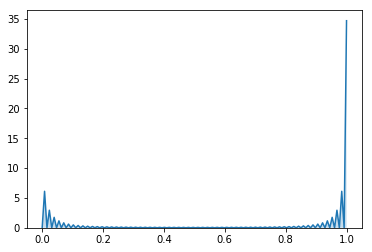

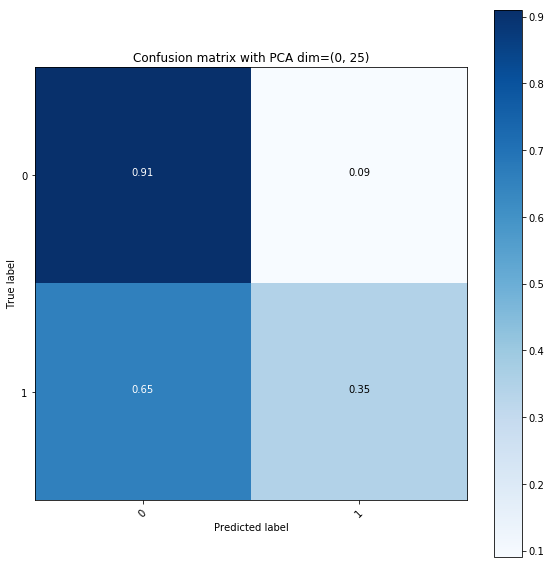

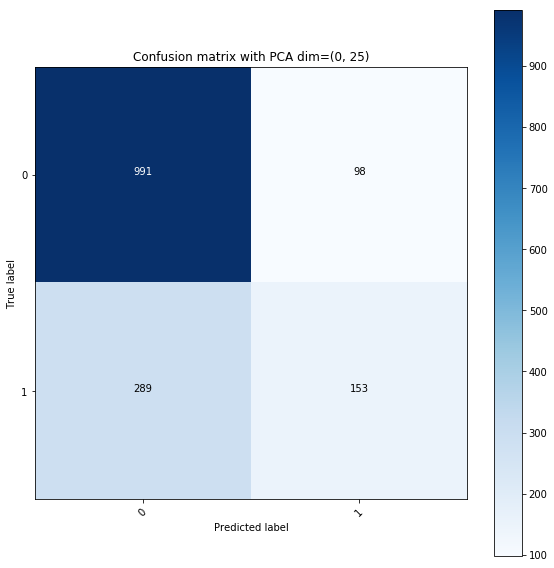

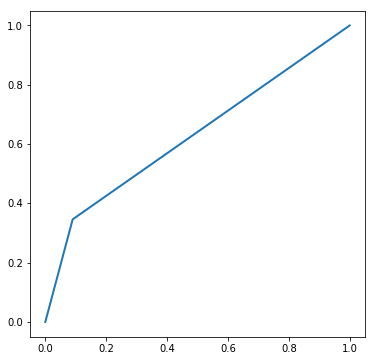

In [100]:
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={}".format(dim))

/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0, 1]

Confusion matrix for all classes : 

[[993  96]
 [287 155]]

Normalized confusion matrix
[[0.91184573 0.08815427]
 [0.64932127 0.35067873]]
Confusion matrix, without normalization
[[993  96]
 [287 155]]

TP rate = [0.         0.35067873 1.        ]
FP rate = [0.         0.08815427 1.        ]


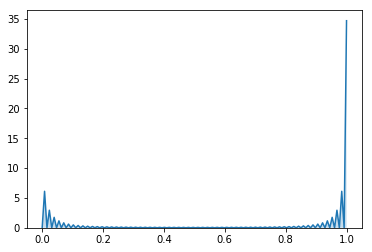

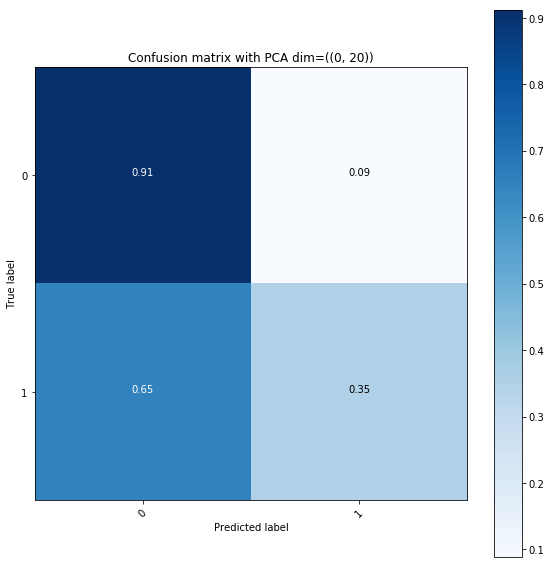

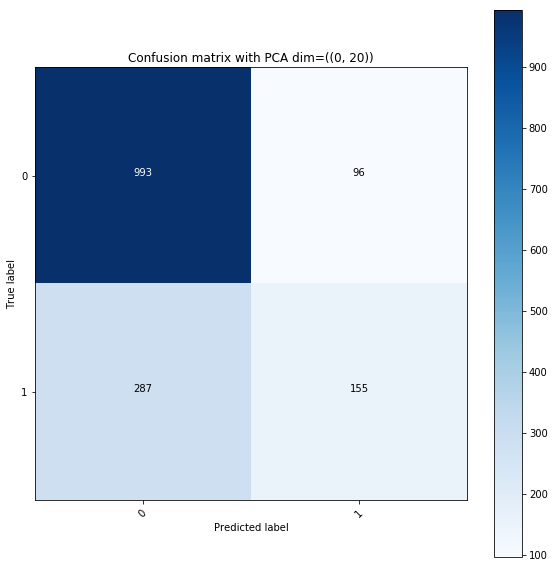

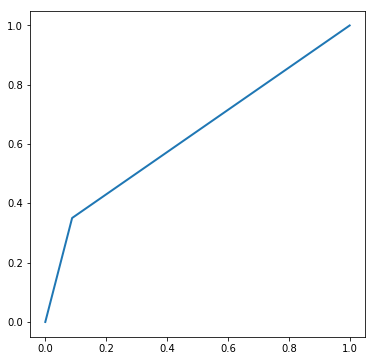

In [94]:
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with PCA dim={}".format(dim))

/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0, 1]

Confusion matrix for all classes : 

[[993  96]
 [287 155]]

Normalized confusion matrix
[[0.91184573 0.08815427]
 [0.64932127 0.35067873]]
Confusion matrix, without normalization
[[993  96]
 [287 155]]

TP rate = [0.         0.35067873 1.        ]
FP rate = [0.         0.08815427 1.        ]


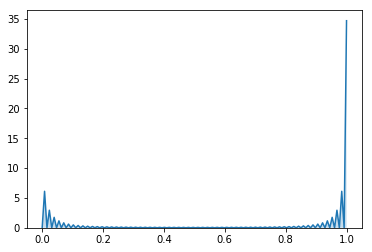

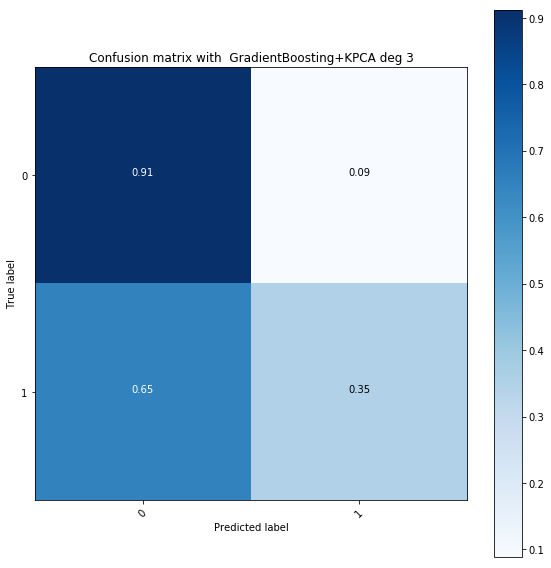

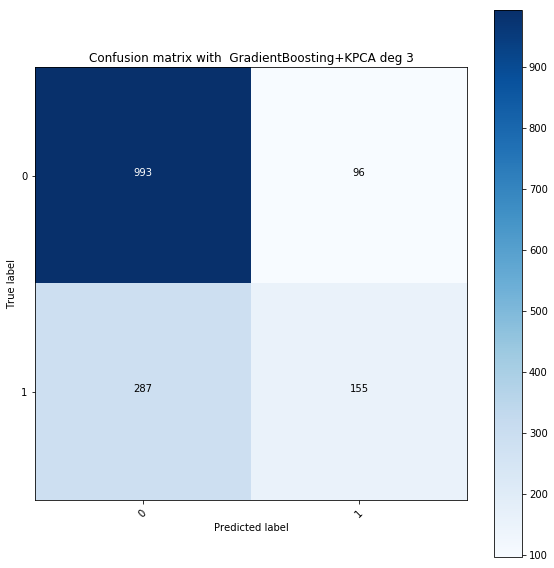

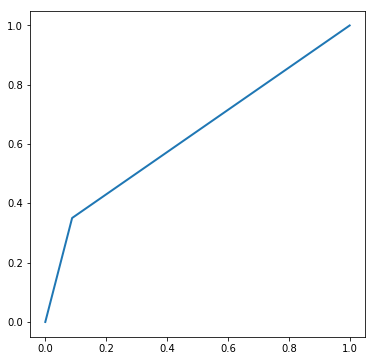

In [92]:
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with  GradientBoosting+KPCA deg "+str(dict_kernel_param['degree']))

/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0, 1]

Confusion matrix for all classes : 

[[766 323]
 [164 278]]

Normalized confusion matrix
[[0.70339761 0.29660239]
 [0.37104072 0.62895928]]
Confusion matrix, without normalization
[[766 323]
 [164 278]]

TP rate = [0.         0.62895928 1.        ]
FP rate = [0.         0.29660239 1.        ]


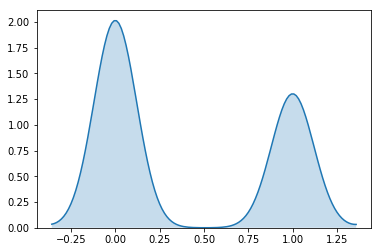

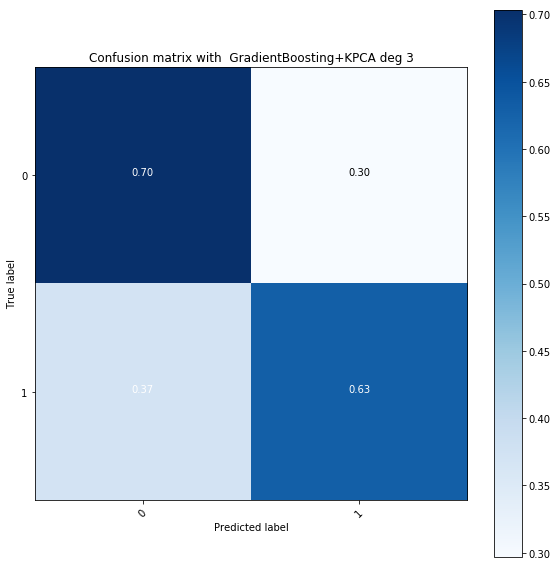

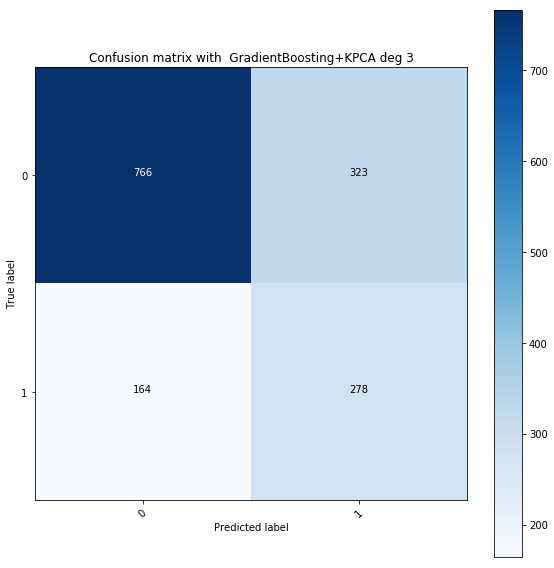

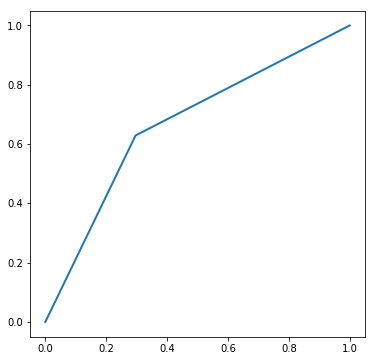

In [68]:
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with  GradientBoosting+KPCA deg "+str(dict_kernel_param['degree']))


Gradient Boosting Classifier: mean accuracy score= 0.7413455258001306
[0, 1]

Confusion matrix for all classes : 

[[994  95]
 [301 141]]

Normalized confusion matrix
[[0.912764   0.087236  ]
 [0.68099548 0.31900452]]
Confusion matrix, without normalization
[[994  95]
 [301 141]]

TP rate = [0.         0.31900452 1.        ]
FP rate = [0.       0.087236 1.      ]


/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


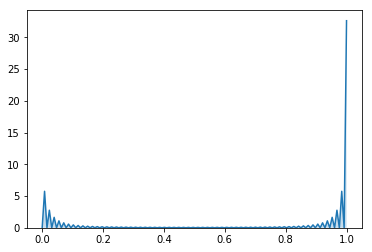

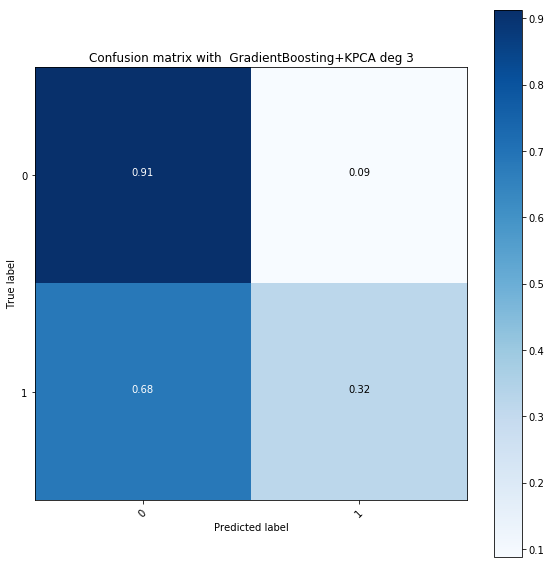

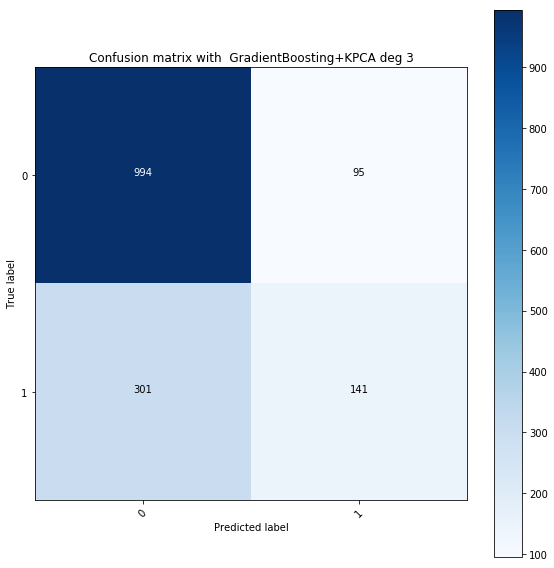

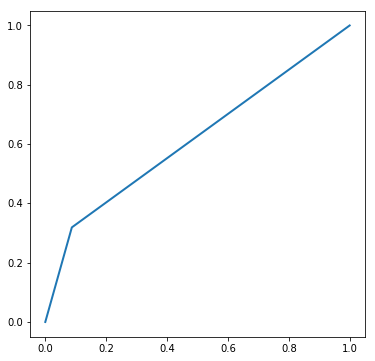

In [52]:
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with  GradientBoosting+KPCA deg "+str(dict_kernel_param['degree']))

## <font color=blus>3.1 Binary Classifier with polynomial kernel</font>

    Build a kernel PCA operator based on previous results, considering dimension number

In [627]:
from sklearn import decomposition

dict_kernel_param['kernel_name']='polynomial'
dict_kernel_param['degree'] = 5

print(dict_kernel_param)


n_components = df_train_sample.shape[1]
parameter_gamma = 1./df_train_sample.shape[1]
kpca = decomposition.KernelPCA(n_components=n_components,\
    kernel=dict_kernel_param['kernel_name'], gamma=parameter_gamma, degree=dict_kernel_param['degree'])

{'kernel_name': 'polynomial', 'degree': 5}


In [628]:
kpca.get_params()

{'alpha': 1.0,
 'coef0': 1,
 'copy_X': True,
 'degree': 5,
 'eigen_solver': 'auto',
 'fit_inverse_transform': False,
 'gamma': 0.01,
 'kernel': 'polynomial',
 'kernel_params': None,
 'max_iter': None,
 'n_components': 100,
 'n_jobs': None,
 'random_state': None,
 'remove_zero_eig': False,
 'tol': 0}

    Transform dataset with PCA operator.
    Backup of sampled and kernel PCA transformed dataset 

In [629]:
import p5_util

X_train_sample = kpca.fit_transform(df_train_sample.values)
X_test_sample  = kpca.transform(df_test_sample.values)
print(X_train_sample.shape)
print(X_test_sample.shape)




degree = dict_kernel_param['degree']
kernel_name = dict_kernel_param['kernel_name']
filename_train = "./data/Xy_train_sample_bin_kpca_"+str(kernel_name)+str(degree)+"_"+str(n_sample)+"_bow.dump"
filename_test  = "./data/Xy_test_sample_bin_kpca_"+str(kernel_name)+str(degree)+"_"+str(n_sample)+"_bow.dump"

p5_util.object_dump((X_train_sample,y_train_label_vect_bin_sample), filename_train )
p5_util.object_dump((X_test_sample, y_test_label_vect_bin_sample), filename_test )

if False :
    (X_train_sample,y_train_label_vect_bin_sample) = p5_util.object_load(filename_train )
    (X_test_sample, y_test_label_vect_bin_sample)  = p5_util.object_load(filename_test )

print("X_train sample shape = {}".format(X_train_sample.shape))
print("y_train sample shape = {}".format(y_train_label_vect_bin_sample.shape))
print("X_test sample shape = {}".format(X_test_sample.shape))
print("y_test sample shape = {}".format(y_test_label_vect_bin_sample.shape))

print("")
print("Number of safe texts  = {}".format(len(np.where(y_test_label_vect_bin_sample==0)[0])))
print("Number of toxics texts= {}".format(len(np.where(y_test_label_vect_bin_sample==1)[0])))

(5000, 100)
(5000, 100)
X_train sample shape = (5000, 100)
y_train sample shape = (5000,)
X_test sample shape = (5000, 100)
y_test sample shape = (5000,)

Number of safe texts  = 4811
Number of toxics texts= 189


    Applying Estimator over transformed dataset.
    Score is computed.
    Prediction is computed over X_test_sample

In [640]:
y_weight = None

In [668]:
import p9_util
y_weight, class_weights = p9_util.build_classweight_vector(y_train_label_vect_bin_sample)
if True :
    class_weights[0] = 0.75
    class_weights[1] = 15.
    print(class_weights)
    y_weight = p9_util.build_vector_from_classweight(y_train_label_vect_bin_sample,class_weights)


Classes weights = [ 0.52148519 12.13592233]


Class : 0 Weight=0.5214851898206091
Class : 1 Weight=12.135922330097088

[ 0.75 15.  ]
Class : 0 Weight=0.75
Class : 1 Weight=15.0



    Classifier performances is evaluated.

In [49]:
X_train_sample.shape,X_test_sample.shape

((4593, 300), (1531, 300))


Gradient Boosting Classifier: mean accuracu score= 0.6759030738164685
[0, 1]

Confusion matrix for all classes : 

[[3267 1544]
 [ 110   79]]

Normalized confusion matrix
[[0.6790688  0.3209312 ]
 [0.58201058 0.41798942]]
Confusion matrix, without normalization
[[3267 1544]
 [ 110   79]]

TP rate = [0.         0.41798942 1.        ]
FP rate = [0.        0.3209312 1.       ]


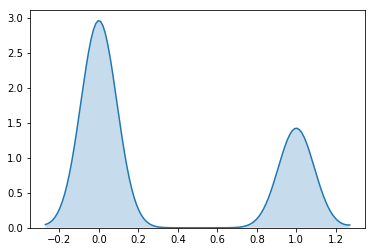

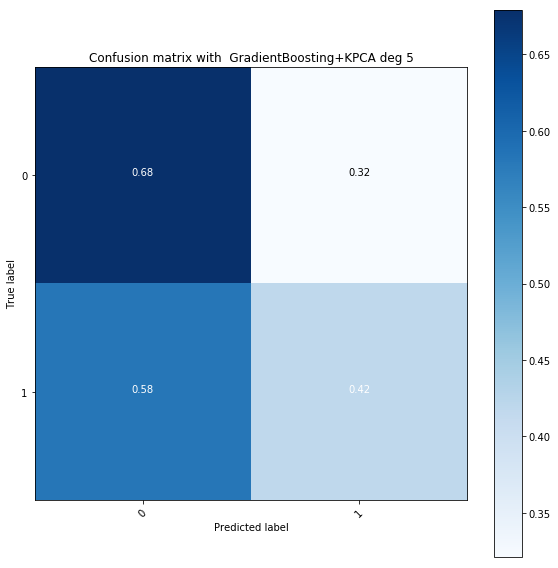

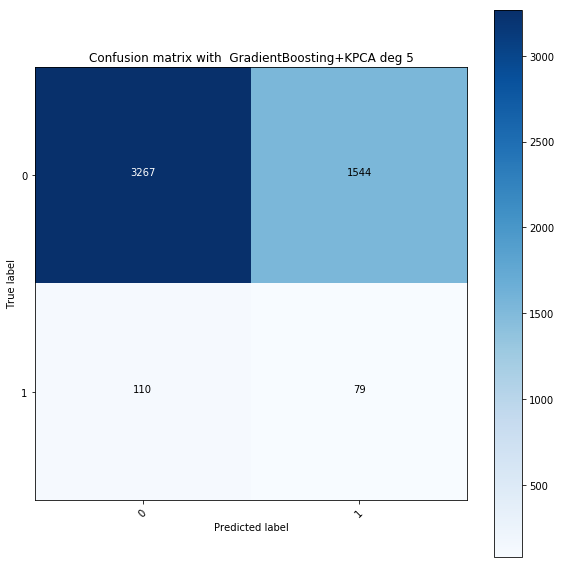

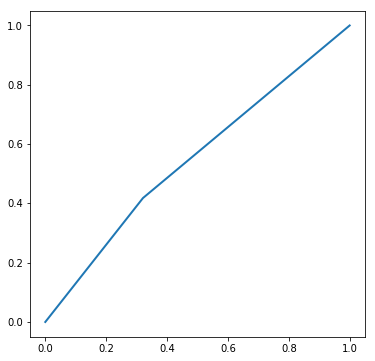

In [671]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim  = 20
higher_dim = 40
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced =   X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracu score= {}".format(mean_acc))

y_pred_sample = model.predict(X_test_sample_reduced)
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with  GradientBoosting+KPCA deg "+str(dict_kernel_param['degree']))

## <font color=blus>3.2 Binary Classifier with Gaussian RBF kernel</font>

In [672]:
from sklearn.metrics.pairwise import rbf_kernel

dict_kernel_param['kernel_name']='rbf'
dict_kernel_param['degree'] = None
parameter_gamma = 1.e-1
print(dict_kernel_param)

dim=500

kmatrix = rbf_kernel(X_train_std[:dim,:], gamma=parameter_gamma)
kmatrix.min(), kmatrix.max()

{'kernel_name': 'rbf', 'degree': None}


(2.826800294489443e-146, 1.0)

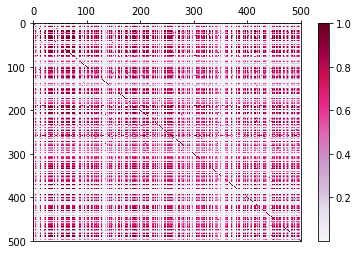

In [602]:
import matplotlib
import matplotlib.pyplot as plt

# dessiner la matrice
plt.pcolor(kmatrix, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# définir les axes
plt.xlim([0, dim])
plt.ylim([0, dim])

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

In [603]:
from sklearn import decomposition

n_components = df_train_sample.shape[1]
kpca = decomposition.KernelPCA(n_components=n_components,\
    kernel=dict_kernel_param['kernel_name'], gamma=parameter_gamma, degree=dict_kernel_param['degree'])

kpca.get_params()

{'alpha': 1.0,
 'coef0': 1,
 'copy_X': True,
 'degree': None,
 'eigen_solver': 'auto',
 'fit_inverse_transform': False,
 'gamma': 0.1,
 'kernel': 'rbf',
 'kernel_params': None,
 'max_iter': None,
 'n_components': 100,
 'n_jobs': None,
 'random_state': None,
 'remove_zero_eig': False,
 'tol': 0}

In [604]:
import p5_util

X_train_sample = kpca.fit_transform(df_train_sample.values)
X_test_sample  = kpca.transform(df_test_sample.values)
print(X_train_sample.shape)
print(X_test_sample.shape)




degree = dict_kernel_param['degree']
kernel_name = dict_kernel_param['kernel_name']
filename_train = "./data/Xy_train_sample_bin_kpca_"+str(kernel_name)+str(parameter_gamma)+"_"+str(n_sample)+"_bow.dump"
filename_test  = "./data/Xy_test_sample_bin_kpca_"+str(kernel_name)+str(parameter_gamma)+"_"+str(n_sample)+"_bow.dump"

p5_util.object_dump((X_train_sample,y_train_label_vect_bin_sample), filename_train )
p5_util.object_dump((X_test_sample, y_test_label_vect_bin_sample), filename_test )

if False :
    (X_train_sample,y_train_label_vect_bin_sample) = p5_util.object_load(filename_train )
    (X_test_sample, y_test_label_vect_bin_sample)  = p5_util.object_load(filename_test )

print("X_train sample shape = {}".format(X_train_sample.shape))
print("y_train sample shape = {}".format(y_train_label_vect_bin_sample.shape))
print("X_test sample shape = {}".format(X_test_sample.shape))
print("y_test sample shape = {}".format(y_test_label_vect_bin_sample.shape))

print("")
print("Number of safe texts  = {}".format(len(np.where(y_test_label_vect_bin_sample==0)[0])))
print("Number of toxics texts= {}".format(len(np.where(y_test_label_vect_bin_sample==1)[0])))

(5000, 100)
(5000, 100)
X_train sample shape = (5000, 100)
y_train sample shape = (5000,)
X_test sample shape = (5000, 100)
y_test sample shape = (5000,)

Number of safe texts  = 3505
Number of toxics texts= 1495



Gradient Boosting Classifier: mean accuracu score= 0.6956
[0, 1]

Confusion matrix for all classes : 

[[3450   55]
 [1467   28]]

Normalized confusion matrix
[[0.98430813 0.01569187]
 [0.9812709  0.0187291 ]]
Confusion matrix, without normalization
[[3450   55]
 [1467   28]]

TP rate = [0.        0.0187291 1.       ]
FP rate = [0.         0.01569187 1.        ]


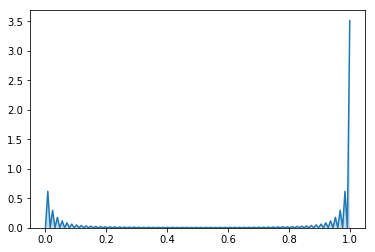

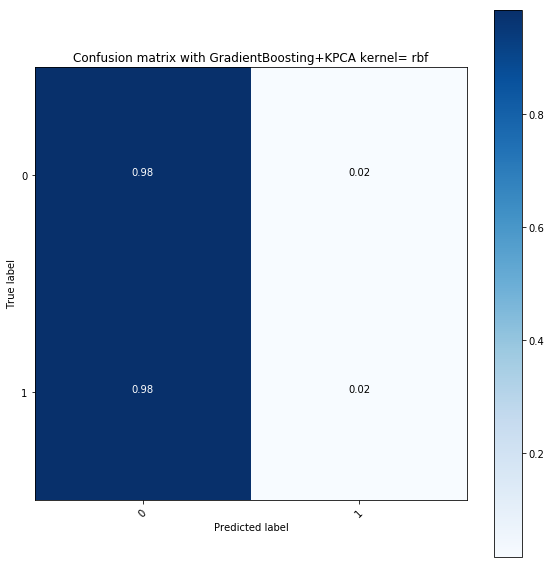

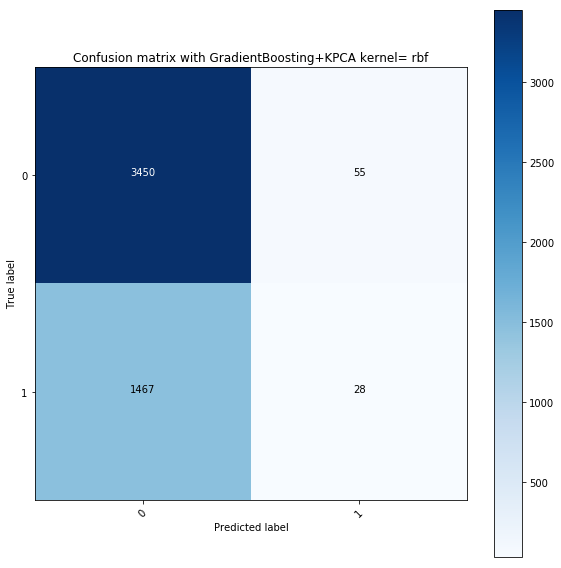

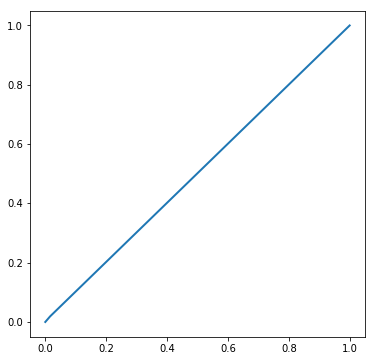

In [605]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

model = GradientBoostingClassifier()
model = model.fit(X_train_sample, y_train_label_vect_bin_sample,sample_weight=None)
mean_acc = model.score(X_test_sample, y_test_label_vect_bin_sample, sample_weight=None)
print("\nGradient Boosting Classifier: mean accuracy score= {}".format(mean_acc))

y_pred_sample = model.predict(X_test_sample)

y_= p9_util.display_class_performance(model, X_test_sample, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title="Confusion matrix with GradientBoosting+KPCA kernel= "+str(dict_kernel_param['kernel_name']))

    Plot of points in the main components planes.


Shape of points to be plot: 


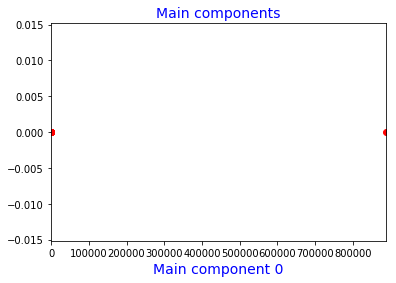

In [466]:
import p3_util_plot
import p3_util

X_train_sample_scaled = p3_util.df_get_std_scaled_values(df_train_sample)
p3_util_plot.X_pca_components_plot(X_train_sample, \
                                   X_train_sample_scaled, \
                                   nb_components=1, \
                                   ratio=1., \
                                   param_title=None,\
                                   x_max_y_max=None)


Shape of points to be plot: 


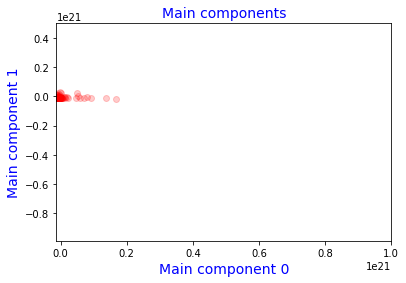

In [318]:
import p3_util_plot
import p3_util

X_train_sample_scaled = p3_util.df_get_std_scaled_values(df_train_sample)
p3_util_plot.X_pca_components_plot(X_train_sample, \
                                   X_train_sample_scaled, \
                                   nb_components=2, \
                                   ratio=1., \
                                   param_title=None,\
                                   x_max_y_max=(0.1e22,0.05e22),\
                                  plane=(0,1))

In [315]:
X_train_sample_scaled.shape
X_train_sample_scaled[:,0].min(), X_train_sample_scaled[:,0].max(),X_train_sample_scaled[:,0].mean(),X_train_sample_scaled[:,0].std()

(-0.3554562628134652,
 10.880862178849322,
 -9.237055564881302e-18,
 0.999999999999999)


Shape of points to be plot: 


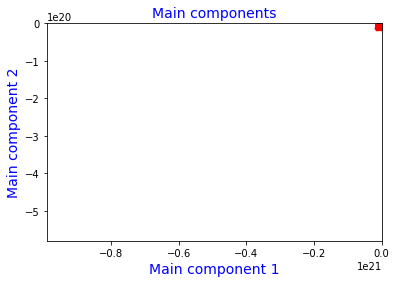

In [319]:
import p3_util_plot
import p3_util

X_train_sample_scaled = p3_util.df_get_std_scaled_values(df_train_sample)
p3_util_plot.X_pca_components_plot(X_train_sample, \
                                   X_train_sample_scaled, \
                                   nb_components=2, \
                                   ratio=1., \
                                   param_title=None,\
                                   x_max_y_max=(3e11, 2.5e12),\
                                  plane=(1,2))


Shape of points to be plot: 


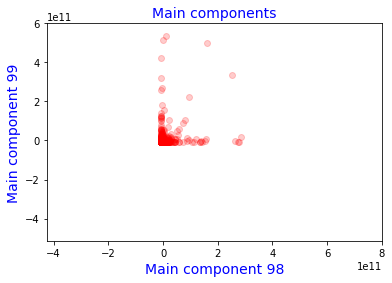

In [231]:
import p3_util_plot
import p3_util

X_train_sample_scaled = p3_util.df_get_std_scaled_values(df_train_sample)
p3_util_plot.X_pca_components_plot(X_train_sample, \
                                   X_train_sample_scaled, \
                                   nb_components=2, \
                                   ratio=1., \
                                   param_title=None,\
                                   x_max_y_max=(0.8e12,6e11),\
                                  plane=(98,99))

    What is the influence of first compenents on classifier performance ?


Gradient Boosting Classifier: mean accuracy score= 0.6964
[0, 1]

Confusion matrix for all classes : 

[[3465   40]
 [1478   17]]

Normalized confusion matrix
[[0.98858773 0.01141227]
 [0.98862876 0.01137124]]
Confusion matrix, without normalization
[[3465   40]
 [1478   17]]

TP rate = [0.         0.01137124 1.        ]
FP rate = [0.         0.01141227 1.        ]


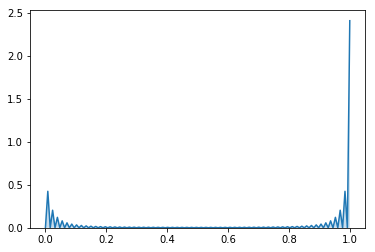

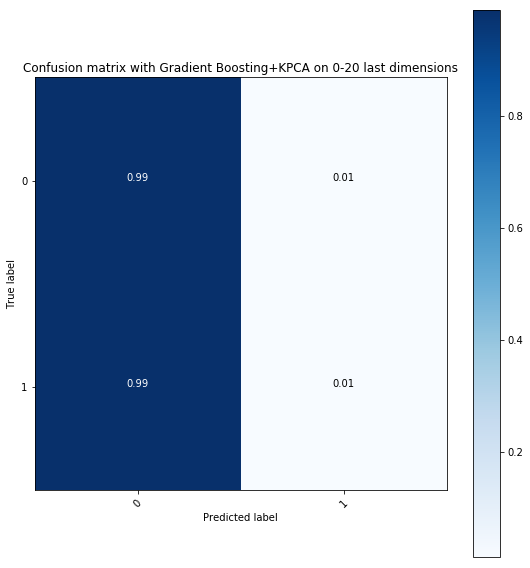

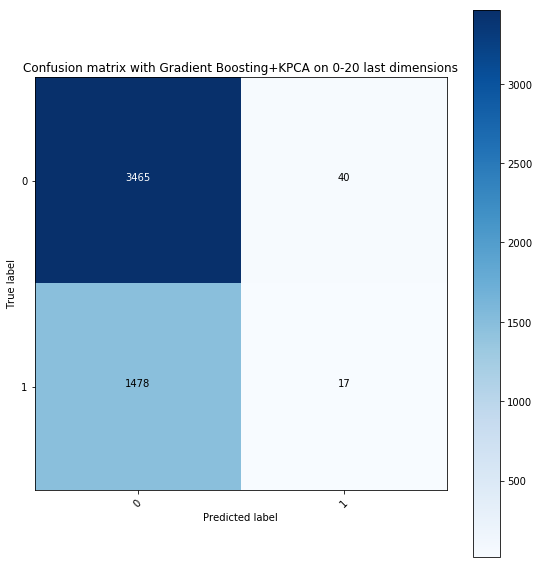

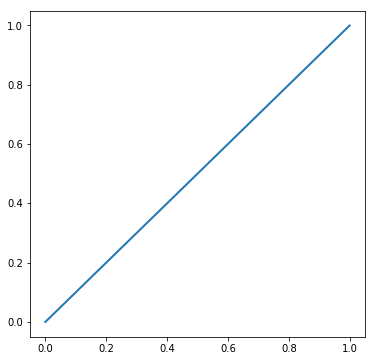

In [487]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim  = 0
higher_dim = 20
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=None)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=None)

print("\nGradient Boosting Classifier: mean accuracy score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on "+str(lower_dim)+"-"+str(higher_dim)+" last dimensions"
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)

    Using weights in Gradient Boosting

In [321]:
y_weight = None

In [280]:
import p9_util
y_weight, class_weights = p9_util.build_classweight_vector(y_train_label_vect_bin_sample)


Classes weights = [0.53293541 8.09061489]


Class : 0 Weight=0.5329354082285227
Class : 1 Weight=8.090614886731391



Weights = None
      Iter       Train Loss   Remaining Time 
         1           0.4582            6.32s
         2           0.4562            6.33s
         3           0.4537            6.55s
         4           0.4528            6.36s
         5           0.4517            6.57s
         6           0.4503            6.85s
         7           0.4485            7.21s
         8           0.4473            7.62s
         9           0.4466            8.36s
        10           0.4446            8.50s
        20           0.4309            8.70s
        30           0.4169            8.50s
        40           0.4049            8.20s
        50           0.3934            7.62s
        60           0.3834            7.25s
        70           0.3727            7.34s
        80           0.3642            7.26s
        90           0.3521            7.01s
       100           0.3423            6.80s
       200           0.2716            5.79s
       300           0.2177            

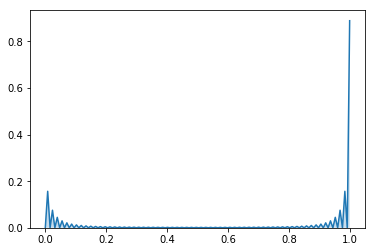

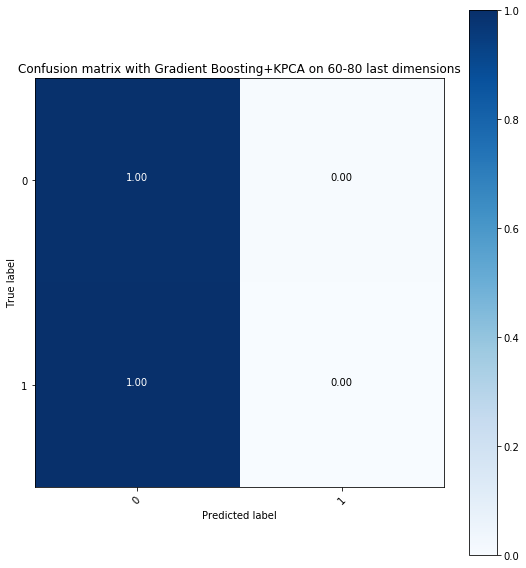

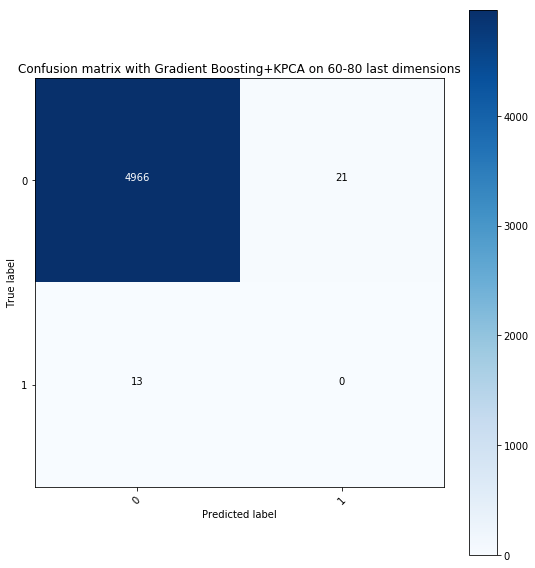

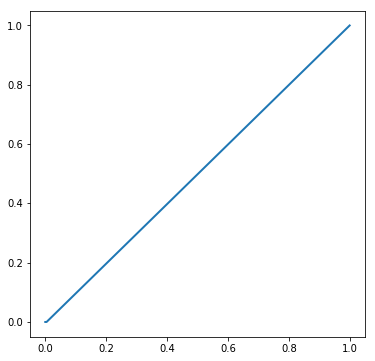

In [322]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim = 60
higher_dim = 80
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]
if y_weight is None : 
    print("Weights = None")
else : 
    print("Weights = "+str(class_weights))
    
n_estimators = 1000 # 50 is default value
max_depth = 3# 3 is default value
verbose = 1 # 0 is default value
model = GradientBoostingClassifier(n_estimators = n_estimators, max_depth=max_depth, verbose=verbose)
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracu score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on "+str(lower_dim)+"-"+str(higher_dim)+" last dimensions"
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)

In [491]:
import p9_util
y_weight, class_weights = p9_util.build_classweight_vector(y_train_label_vect_bin_sample)


Classes weights = [0.70701357 1.70765027]


Class : 0 Weight=0.7070135746606335
Class : 1 Weight=1.7076502732240437



In [497]:
import p9_util
class_weights[0] = 1.
class_weights[1] = 2*class_weights[1]
print(class_weights)
y_weight = p9_util.build_vector_from_classweight(y_train_label_vect_bin_sample,class_weights)

[1.         3.41530055]
Class : 0 Weight=1.0
Class : 1 Weight=3.4153005464480874




Gradient Boosting Classifier: mean accuracu score= 0.4181973102667711
[0, 1]

Confusion matrix for all classes : 

[[ 903 2602]
 [ 333 1162]]

Normalized confusion matrix
[[0.25763195 0.74236805]
 [0.22274247 0.77725753]]
Confusion matrix, without normalization
[[ 903 2602]
 [ 333 1162]]

TP rate = [0.         0.77725753 1.        ]
FP rate = [0.         0.74236805 1.        ]


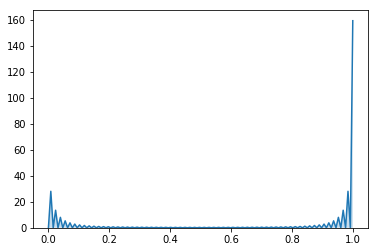

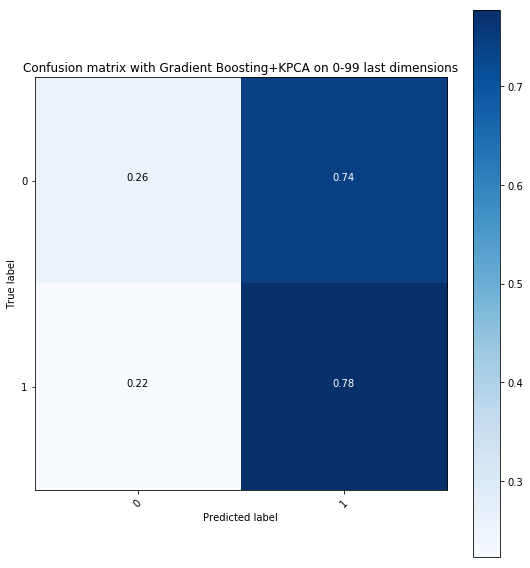

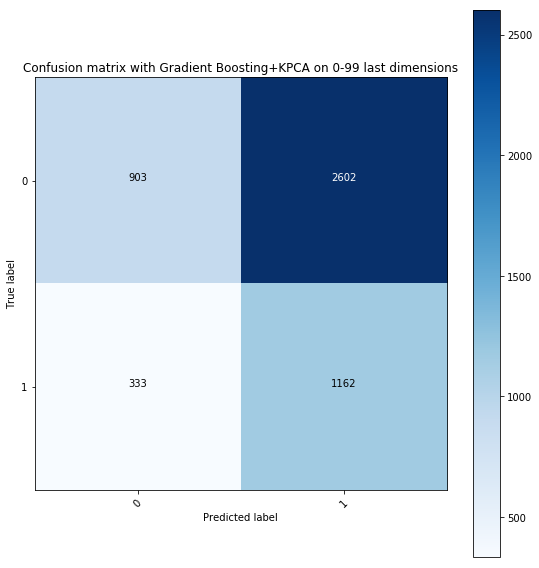

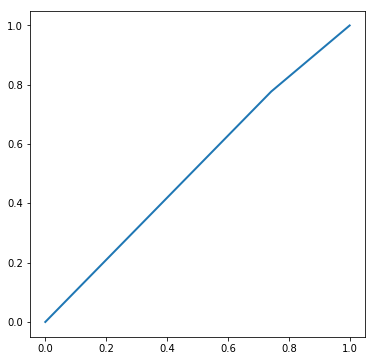

In [498]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim  = 0
higher_dim = 99
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracu score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on "+str(lower_dim)+"-"+str(higher_dim)+" last dimensions"
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)

In [296]:
import p9_util
class_weights[1] = class_weights[1]/2
print(class_weights)
y_weight = p9_util.build_vector_from_classweight(y_train_label_vect_bin_sample,class_weights)

[ 0.50184008 34.09090909]
Class : 0 Weight=0.5018400802944128
Class : 1 Weight=34.09090909090909




Gradient Boosting Classifier: mean accuracu score= 0.9968
[0, 1]

Confusion matrix for all classes : 

[[4984    3]
 [  13    0]]

Normalized confusion matrix
[[9.99398436e-01 6.01564067e-04]
 [1.00000000e+00 0.00000000e+00]]
Confusion matrix, without normalization
[[4984    3]
 [  13    0]]

TP rate = [0. 0. 1.]
FP rate = [0.00000000e+00 6.01564067e-04 1.00000000e+00]


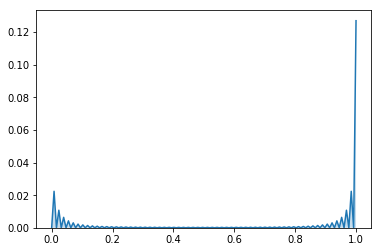

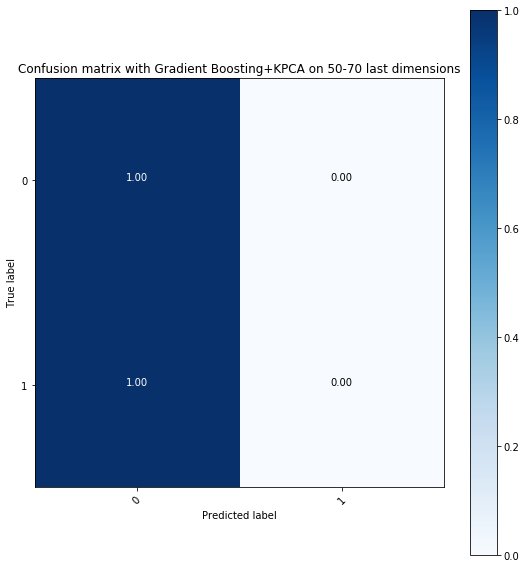

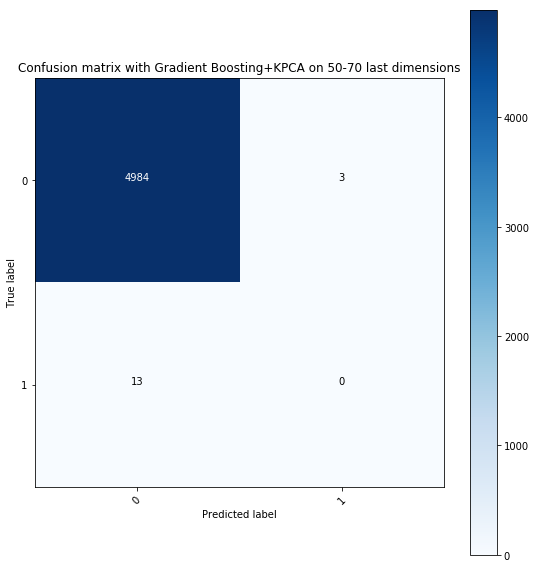

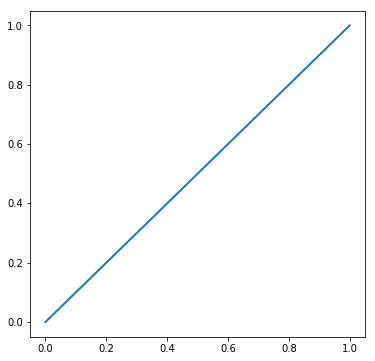

In [324]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim = 50
higher_dim = 70
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracu score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on "+str(lower_dim)+"-"+str(higher_dim)+" last dimensions"
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)

In [488]:
y_weight=None


Gradient Boosting Classifier: mean accuracu score= 0.6954
[0, 1]

Confusion matrix for all classes : 

[[3466   39]
 [1484   11]]

Normalized confusion matrix
[[0.98887304 0.01112696]
 [0.99264214 0.00735786]]
Confusion matrix, without normalization
[[3466   39]
 [1484   11]]

TP rate = [0.         0.00735786 1.        ]
FP rate = [0.         0.01112696 1.        ]


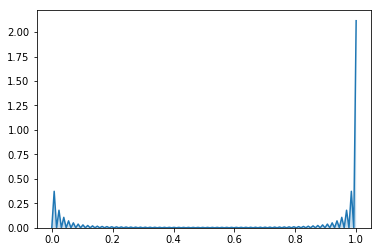

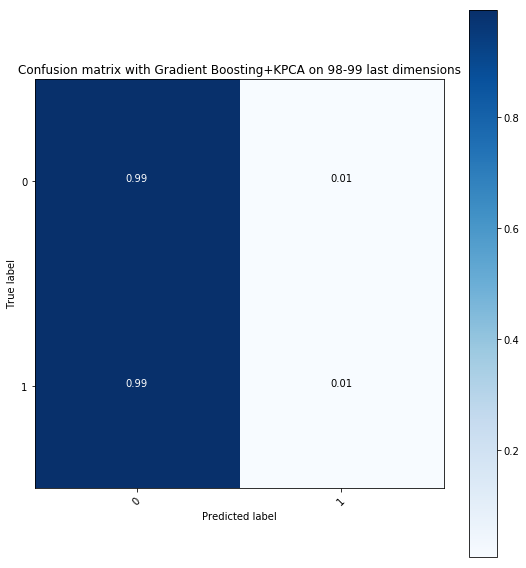

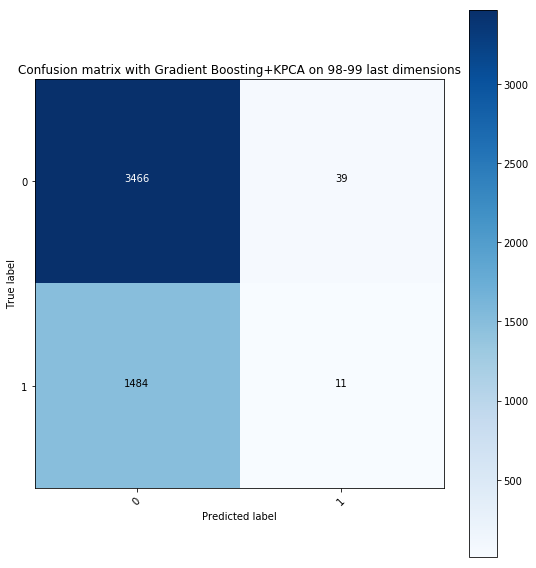

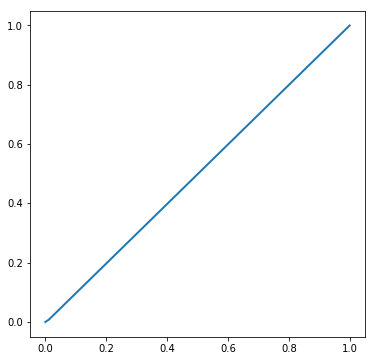

In [490]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim = 98
higher_dim = 99
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracu score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on "+str(lower_dim)+"-"+str(higher_dim)+" last dimensions"
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)


Gradient Boosting Classifier: mean accuracu score= 0.996
[0, 1]

Confusion matrix for all classes : 

[[4980    7]
 [  13    0]]

Normalized confusion matrix
[[0.99859635 0.00140365]
 [1.         0.        ]]
Confusion matrix, without normalization
[[4980    7]
 [  13    0]]

TP rate = [0. 0. 1.]
FP rate = [0.         0.00140365 1.        ]


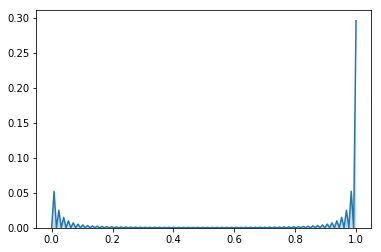

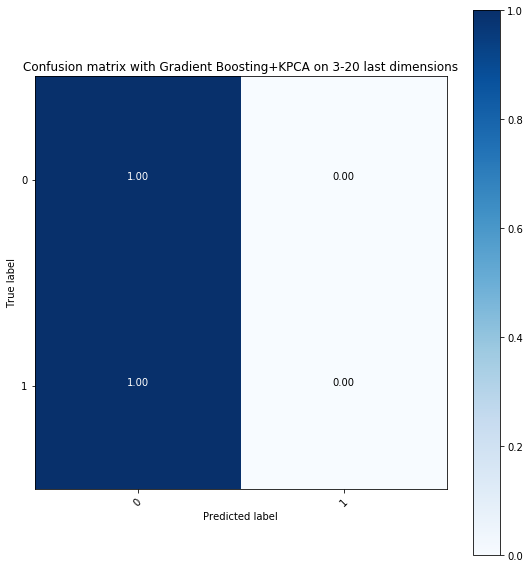

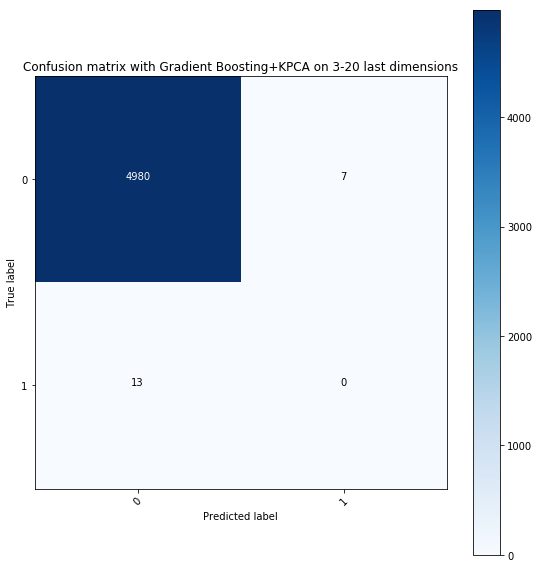

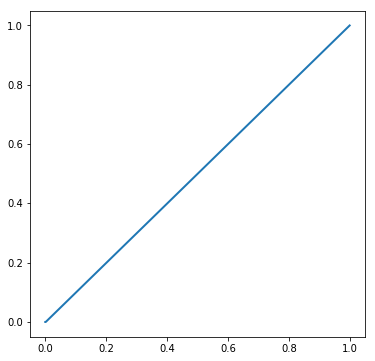

In [331]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim = 3
higher_dim = 20
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracy score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on "+str(lower_dim)+"-"+str(higher_dim)+" last dimensions"
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)

In [353]:
import p9_util
y_weight, class_weights = p9_util.build_classweight_vector(y_train_label_vect_bin_sample)
class_weights[1] = 11
y_weight = p9_util.build_vector_from_classweight(y_train_label_vect_bin_sample,class_weights)


Classes weights = [0.53293541 8.09061489]


Class : 0 Weight=0.5329354082285227
Class : 1 Weight=8.090614886731391

Class : 0 Weight=0.5329354082285227
Class : 1 Weight=11.0




Gradient Boosting Classifier: mean accuracu score= 0.45145423699278936
[0, 1]

Confusion matrix for all classes : 

[[2322 2665]
 [   9    4]]

Normalized confusion matrix
[[0.46561059 0.53438941]
 [0.69230769 0.30769231]]
Confusion matrix, without normalization
[[2322 2665]
 [   9    4]]

TP rate = [0.         0.30769231 1.        ]
FP rate = [0.         0.53438941 1.        ]


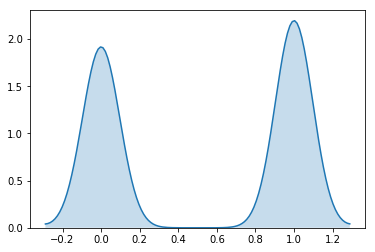

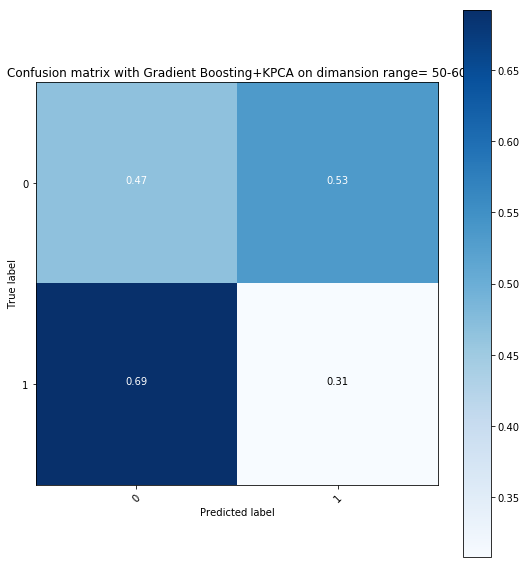

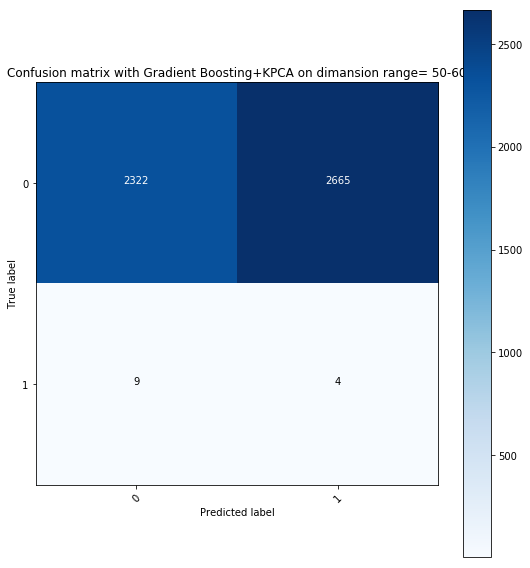

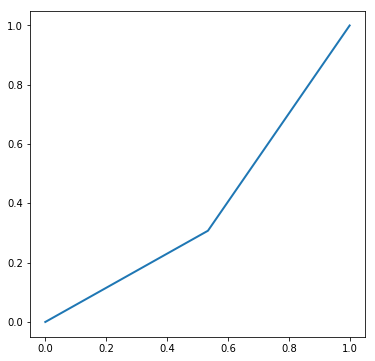

In [356]:
from sklearn.ensemble import GradientBoostingClassifier
import p9_util

lower_dim = 50
higher_dim = 60
X_train_sample_reduced = X_train_sample[:,lower_dim:higher_dim]
X_test_sample_reduced = X_test_sample[:,lower_dim:higher_dim]


model = GradientBoostingClassifier()
model = model.fit(X_train_sample_reduced, y_train_label_vect_bin_sample,sample_weight=y_weight)
mean_acc = model.score(X_test_sample_reduced, y_test_label_vect_bin_sample, sample_weight=y_weight)

print("\nGradient Boosting Classifier: mean accuracu score= {}".format(mean_acc))
y_pred_sample = model.predict(X_test_sample_reduced)

title = "Confusion matrix with Gradient Boosting+KPCA on dimansion range= "+str(lower_dim)+"-"+str(higher_dim)
y_= p9_util.display_class_performance(model, X_test_sample_reduced, y_test_label_vect_bin_sample, 
                                      is_binary=True, nb_classes=2, y_pred=y_pred_sample, 
                                      title=title)

## <font color=blus>2.2 Cost Specificity Learning</font>

    Building weights vector from class_weights.

# <font color=blus>4. Ensemble learning classifiers</font>

In [131]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

#### <font color=blus>Extract a random sample from train dataset</font>

In [133]:
import pandas as pd
n_sample = -1
if n_sample >0 :
    df = pd.DataFrame(X_train).sample(n_sample)
    y_train_label_vect_bin_sample = y_train_label_vect_bin[df.sample(n_sample).index]
    X_train_sample = df.values
else :
    X_train_sample = X_train.copy()
    y_train_label_vect_bin_sample = y_train_label_vect_bin.copy()

X_train_sample.shape, y_train_label_vect_bin_sample.shape

((361241, 100), (361241,))

#### <font color=blus>Classes weights vector</font>

    Due to unbalanced classes, class weight vector is computed and assigned to any case.

In [284]:
import p9_util
y_weight, class_weights = p9_util.build_classweight_vector(y_train_label_vect_bin_sample)


Classes weights = [  0.50184008 136.36363636]


Class : 0 Weight=0.5018400802944128
Class : 1 Weight=136.36363636363637



## <font color=blus>4.1. AdaBoost classifier</font>

In [142]:
if False :
    model = XGBClassifier(n_jobs=4)
    model.fit(X_train_sample, y_train_label_vect_bin_sample, sample_weight=class_weights)
else :
    model =AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
        learning_rate=1.0, n_estimators=200, random_state=0)
if len(y_weight >0):
    sample_weight = y_weight.copy()
else : 
    sample_weight = None


model.fit(X_train_sample, y_train_label_vect_bin_sample,sample_weight=y_weight)
    

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=0)

    Mean accuracy is computed along with weight vector used for train step.

In [178]:
import p9_util

y_weight, _ = p9_util.build_classweight_vector(y_test_label_vect_bin, class_weights=class_weights)
mean_acc = model.score(X_test, y_test_label_vect_bin, sample_weight=y_weight)
print("\nMean accuracy = {}".format(mean_acc))


Classes weights = [0.5315338  8.42800149]


Class : 0 Weight=0.5315337982990495
Class : 1 Weight=8.428001493164109


Mean accuracy = 0.5407240829604668


[0, 1]

Confusion matrix for all classes : 

[[95577 81788]
 [  208   290]]

Normalized confusion matrix
[[0.53887182 0.46112818]
 [0.41767068 0.58232932]]

TP rate = [0.         0.58232932 1.        ]
FP rate = [0.         0.46112818 1.        ]


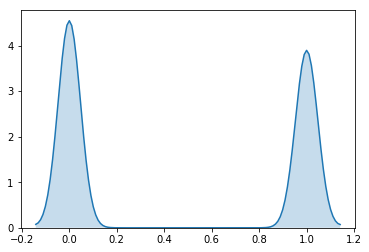

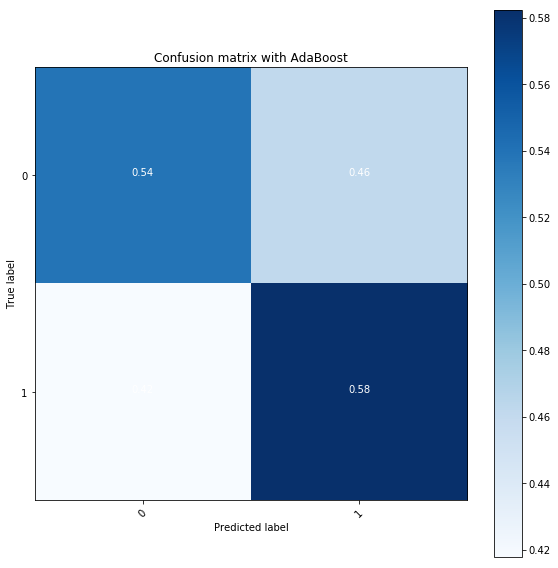

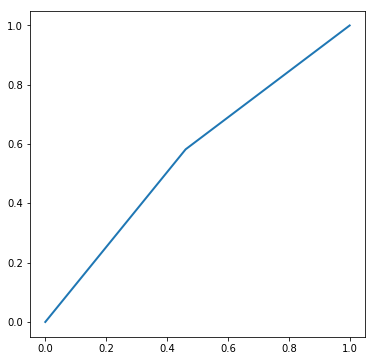

In [179]:
y_pred = model.predict(X_test)

import p9_util
y_= p9_util.display_class_performance(model, X_test, y_test_label, is_binary=True, y_pred=y_pred, title="Confusion matrix with AdaBoost")

### <font color=blus>3.2 Gradient Boosting classifier</font>

In [146]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()

In [148]:
model.fit(X_train_sample, y_train_label_vect_bin_sample,sample_weight=y_weight)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [180]:
model.score(X_test, y_test_label_vect_bin, sample_weight=y_weight)

0.5407240829604668

[0, 1]

Confusion matrix for all classes : 

[[95577 81788]
 [  208   290]]

Normalized confusion matrix
[[0.53887182 0.46112818]
 [0.41767068 0.58232932]]

TP rate = [0.         0.58232932 1.        ]
FP rate = [0.         0.46112818 1.        ]


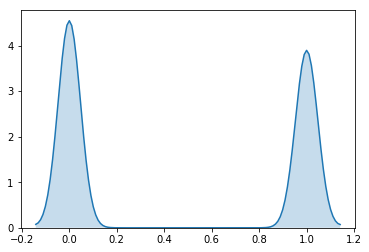

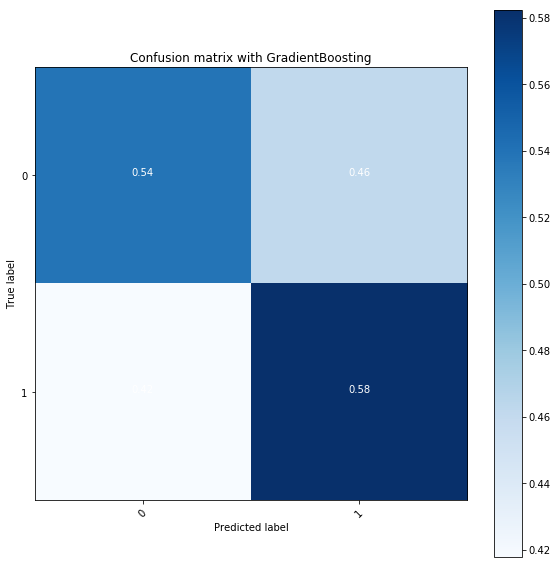

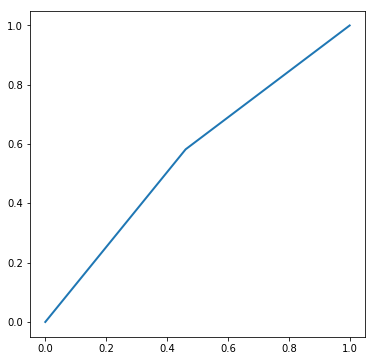

In [181]:
y_pred = model.predict(X_test)

import p9_util
y_= p9_util.display_class_performance(model, X_test, y_test_label, is_binary=True, y_pred=y_pred, title="Confusion matrix with GradientBoosting")

# <font color=blus>5. Gradient boosting over 1st dimention</font>

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import p5_util

filename = './data/DataPreparator_train_v2_spacy_notfidf_20000.dill'
dataPreparator_v2_train = p5_util.object_load(filename)

p5_util.object_load : fileName= ./data/DataPreparator_train_v2_spacy_notfidf_20000.dill


Using TensorFlow backend.
W0909 00:06:08.476597 140440647243584 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0909 00:06:08.477668 140440647243584 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0909 00:06:08.493821 140440647243584 deprecation_wrapper.py:119] From /home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p8_util_config.py:137: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



In [4]:
import p5_util

filename = './data/DataPreparator_v2_spacy_valid_1000.dill'
dataPreparator_v2_valid = p5_util.object_load(filename)

p5_util.object_load : fileName= ./data/DataPreparator_v2_spacy_valid_1000.dill


## <font color=blus>5.1. `DataGenerator` for train dataset</font>

In [5]:
import numpy as np

data_column_name = 'matrix_padded_truncated'

X_train = np.array(dataPreparator_v2_train.df_data[data_column_name].tolist())
y_train = np.array(dataPreparator_v2_train.df_data['target'].tolist())

print(X_train.shape, y_train.shape)

(17366, 80, 34) (17366,)


In [41]:
import numpy as np
data_column_name = 'matrix_padded_truncated'

if True :
    pass
else :
    print("Validation dataset reworked...")
    dataPreparator_v2_valid.df_data = dataPreparator_v2_train.df_data.loc[0:100]

X_valid = np.array(dataPreparator_v2_valid.df_data[data_column_name].tolist())
y_valid = np.array(dataPreparator_v2_valid.df_data['target'].tolist())
print(X_valid.shape, y_valid.shape)

(860, 80, 34) (860,)


## <font color=blus>5.2. Building partitions with `build_generators` function</font>

In [6]:
import test_datapreparator

nb_channel = X_train.shape[-1]
input_dim = dataPreparator_v2_train.max_length
dict_param = {'dim': (input_dim,0),
              'batch_size': 100,
              'n_classes': 0,
              'n_channels': 0,
              'nb_channel': nb_channel,
              'shuffle': False,
              'is_mux' : True
}
print("")
for key, value in dict_param.items() :
    print("{} : {}".format(key,value))


partition_size = 1000
train_generator = test_datapreparator.build_generator(dataPreparator_v2_train, \
                     partition_size,\
                     dict_param,\
                     data_column_name='matrix_padded_truncated',\
                     data_type='train')


dim : (80, 0)
batch_size : 100
n_classes : 0
n_channels : 0
nb_channel : 34
shuffle : False
is_mux : True
Building train partition...



In [42]:
nb_channel = X_valid.shape[-1]
input_dim = dataPreparator_v2_valid.max_length
dict_param = {'dim': (input_dim,0),
              'batch_size': 100,
              'n_classes': 0,
              'n_channels': 0,
              'nb_channel': nb_channel,
              'shuffle': False,
              'is_mux' : True
}
print("")
for key, value in dict_param.items() :
    print("{} : {}".format(key,value))

import test_datapreparator

partition_size = 100
valid_generator = test_datapreparator.build_generator(dataPreparator_v2_valid, \
                     partition_size,\
                     dict_param,\
                     data_column_name='matrix_padded_truncated',\
                     data_type='valid')


dim : (80, 0)
batch_size : 100
n_classes : 0
n_channels : 0
nb_channel : 34
shuffle : False
is_mux : True
Building valid partition...



In [109]:
train_generator.get_params()

{'dim': (80, 0),
 'batch_size': 100,
 'n_classes': 0,
 'n_channels': 0,
 'shuffle': False,
 'nb_channel': 34}

In [32]:
# Get all textes projected on a given dimension


# Create an array to host all textes projected on a given dimension
def get_Xproj_y_from_generator(generator, dimension) :
    nb_token = generator.get_params()['dim'][0]
    x_proj = np.zeros((generator.nb_record, nb_token))
    y = np.zeros((generator.nb_record))

    end_slide = 0
    start_slide = 0

    for i in range(len(generator)) : 
        list_X, Y =generator[i]
        X = np.array(list_X)
        nb_record = X.shape[1]
        try :
            end_slide += nb_record
            x_proj[start_slide: end_slide] = X[dimension,:,:,0]
            y[start_slide: end_slide:] = Y
            start_slide = end_slide
        except ValueError as valueError :
            print("Error : {}".format(valueError))
            print("Record : {}".format(i))
            break
    return x_proj,y


In [170]:
import p3_util_plot
pca = dataPreparator_v2_train.xpca
var_percent = 0.2
nb_component = p3_util_plot.get_component_from_cum_variance(pca, var_percent) 
proj_dimension = nb_component-1
print("\nComponent ID= {} for variance= {}%".format(proj_dimension, var_percent*100))


Component ID= 0 for variance= 20.0%


    Get X and y for train and validation dataset samples, both projected over the given dimension.

In [171]:
x_train_proj , y_train = get_Xproj_y_from_generator(train_generator, proj_dimension)
print("Train dataset shapes :      {}".format((x_train_proj.shape, y_train.shape)))

x_valid_proj , y_valid = get_Xproj_y_from_generator(valid_generator, proj_dimension)

print("Validation dataset shapes : {}".format((x_valid_proj.shape, y_valid.shape)))

y_train_label_vect_bin = dataPreparator_v2_train.vectorValue2BinaryvectorLabel(vector_value=y_train)
y_valid_label_vect_bin = dataPreparator_v2_valid.vectorValue2BinaryvectorLabel(vector_value=y_valid)

Train dataset shapes :      ((17366, 80), (17366,))
Validation dataset shapes : ((860, 80), (860,))


In [172]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(max_depth=6,n_estimators=200,)

model.fit(x_train_proj, y_train_label_vect_bin,sample_weight=None)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

0.6953488372093023
[0, 1]

Confusion matrix for all classes : 

[[583  31]
 [231  15]]

Normalized confusion matrix
[[0.9495114  0.0504886 ]
 [0.93902439 0.06097561]]
Confusion matrix, without normalization
[[583  31]
 [231  15]]

TP rate = [0.         0.06097561 1.        ]
FP rate = [0.        0.0504886 1.       ]


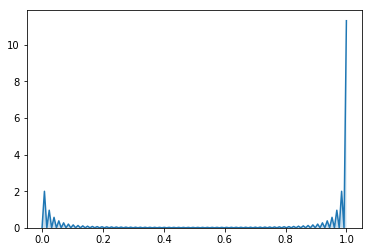

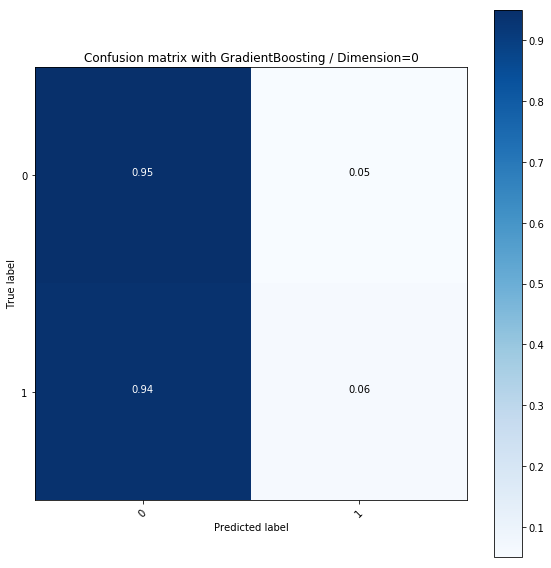

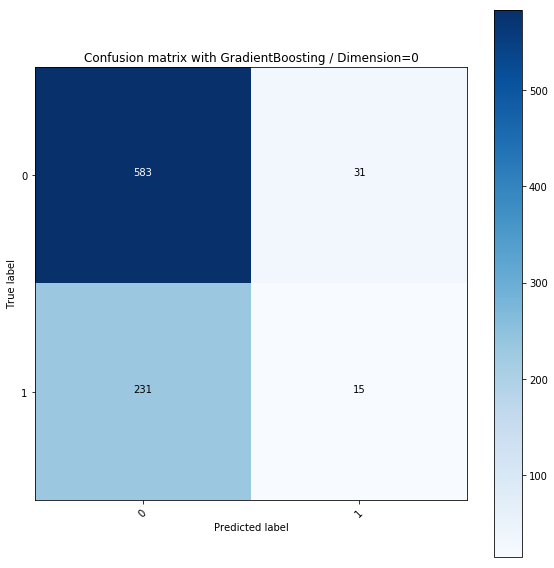

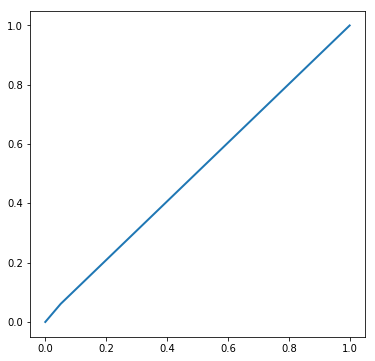

In [173]:
print(model.score(x_valid_proj, y_valid_label_vect_bin, sample_weight=None))

y_pred = model.predict(x_valid_proj)
title="Confusion matrix with GradientBoosting / Dimension={}".format(proj_dimension)
import p9_util
y_= p9_util.display_class_performance(model, x_valid_proj, \
                                      y_valid_label_vect_bin, is_binary=True, \
                                      y_pred=y_pred, \
                                      nb_classes=2,\
                                      title=title)

[0, 1]

Confusion matrix for all classes : 

[[ 67 547]
 [ 27 219]]

Normalized confusion matrix
[[0.10912052 0.89087948]
 [0.1097561  0.8902439 ]]
Confusion matrix, without normalization
[[ 67 547]
 [ 27 219]]

TP rate = [0.        0.8902439 1.       ]
FP rate = [0.         0.89087948 1.        ]


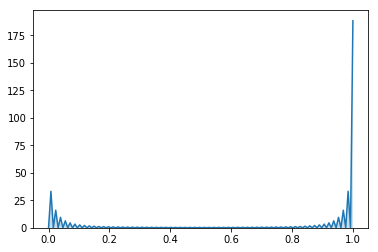

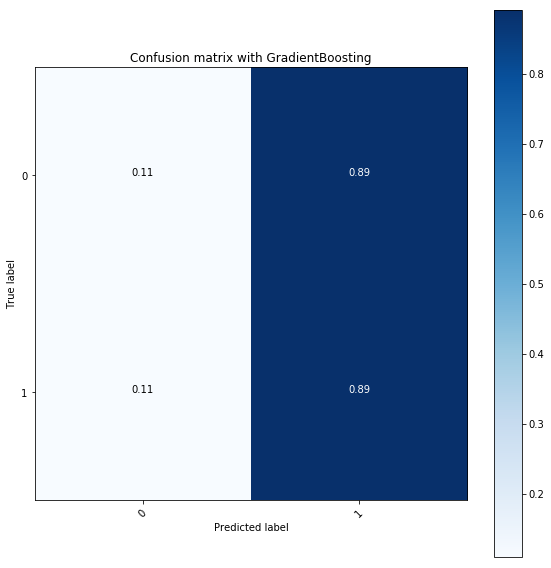

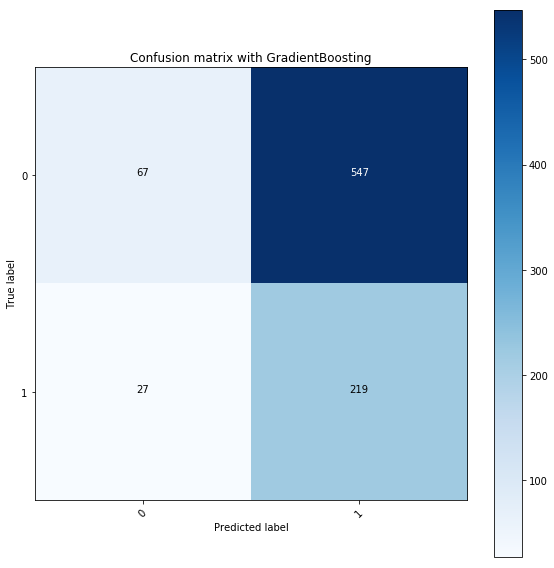

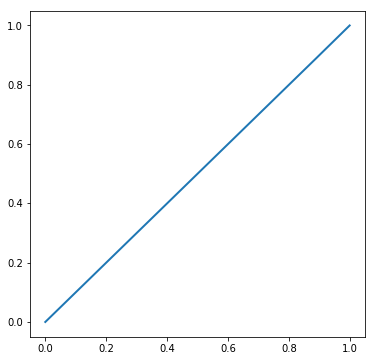

In [59]:
y_pred = model.predict(x_valid_proj)

import p9_util
y_= p9_util.display_class_performance(model, x_valid_proj, \
                                      y_valid_label_vect_bin, is_binary=True, \
                                      y_pred=y_pred, \
                                      nb_classes=2,\
                                      title="Confusion matrix with GradientBoosting")

In [48]:
y_valid_label_vect_bin.shape

(860,)

In [51]:
y_valid_label_vect_bin[:10], y_pred[:100]

(array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))